In [26]:
from DHI_functions import *

Some more work expected at TS_Class and DataExplorer, others used as imported from functions.

TO DO: 
* reorganize code - move plotting to Plotting class, order methods in meaningful way, ancillary methods under the main ones in which they are applied
* finish the docstrings
* make a list of attributes of each class in the class docstring
* decide about public and non-public methods, add "\_" to the beginning of the non-public methods' names

In [2]:
#print(vars(ts_data).keys())

In [3]:
#[ x for x in dir(ts_data) if not x.startswith("_")]

In [4]:
#[ x for x in dir(TS_Class) if not x.startswith("_")]

## new functions

# TO DO:
* correct mistakes
* plot corrected TS + marked categories of observations (orginal values)
* summaries of event categories - append was deprecated and concat does not work

In [210]:
def outliers_ext_indic(outlier_indic, ext_by=1):
    """Extend integer indeces around already present indeces by given number of observations."""
    extended_indices = []
    for i in outlier_indic:
        for j in range(ext_by,0,-1):  # decreasing positive j
            if (i-j) not in extended_indices:
                extended_indices.append(i - j)  # Add the rows above
        for j in range(ext_by+1):
            if (i+j) not in extended_indices:
                extended_indices.append(i + j)      # Add the chosen row and the rows below
    return sorted(extended_indices) 

def centered_ewm(series, alpha, ignore_na=False):
    """Calculates centered exponentially weighted moving average."""
    forward = series.ewm(alpha=alpha, ignore_na=ignore_na).mean()
    backward = series.iloc[::-1].ewm(alpha=alpha, ignore_na=ignore_na).mean().iloc[::-1]
    result = (forward + backward)/2
    return result
    
def correct_data(data, corr_var, date_col="date",
                 outliers_window=1,
                 volatility_window=5, corr_vol=False,
                 zeros_window=15, zeros_ewm=False, zeros_alpha=0.6, zeros_ignore_na=False,
                 const_window=15, const_ewm=False, const_alpha=0.6, const_ignore_na=False):
    """
    Creating corrected data. Currently, everything as short-term corrections + combination of naive corrections.
    Prolonged drops not corrected at all. Volatile rain is considered as OK.
    """
    
    def mean_around(series):
        center = int(len(series)/2)
        center_index = series.index[center]
        mean = series.drop(center_index).mean()
        return mean
    
    # initialize as OK observations, ie OK and volatile rain
    data[corr_var + "_corrected_"] = data[corr_var + "_OK"].fillna(data[corr_var + "_volatile_rain"])  
    
    if corr_vol:  # if to correct volatility
        vol_indic = data[corr_var + "_category"] == "volatile"
        vol_correction = data[corr_var].rolling(volatility_window, center=True).mean()  # smoothing by MA
        data.loc[vol_indic, corr_var + "_corrected_"] = vol_correction[vol_indic]
    else:    # if just keep original values where volatile
        data[corr_var + "_corrected_"] = data[corr_var + "_corrected_"].fillna(data[corr_var + "_volatile"])  
    
    # outliers
    outlier_indic = data[corr_var + "_category"] == "outlier"
    outlier_ext_indic = outliers_ext_indic(data.index[outlier_indic], outliers_window)  # add observations around outliers
    outliers_correction = data[corr_var][outlier_ext_indic].rolling(2*outliers_window+1, center=True).apply(mean_around) 
    outlier_to_zero = outliers_correction == 0   # if outlier is surrounded by zero values...
    outliers_correction.loc[outlier_to_zero.index] = data.loc[outlier_to_zero.index,corr_var]   # better keep its original value
    data.loc[outlier_indic, corr_var + "_corrected_"] = outliers_correction[outlier_indic]
    
    
    # zero values
    zeros_indic = data[corr_var + "_category"] == "zero_value"
    if zeros_ewm:   # use exponentially weighted moving averages
        zeros_correction = centered_ewm(data[corr_var + "_corrected_"], zeros_alpha, zeros_ignore_na)
    else:     # use ordinary moving averages
        zeros_correction = data[corr_var + "_corrected_"].rolling(zeros_window ,min_periods=1, center=True).mean()  # effectively np.nanmean
    data.loc[zeros_indic, corr_var + "_corrected_"] = zeros_correction[zeros_indic]
    
    # constant values
    const_indic = data[corr_var + "_category"] == "const_value"
    if const_ewm:   # use exponentially weighted moving averages
        const_correction = centered_ewm(data[corr_var + "_corrected_"], const_alpha, const_ignore_na)
    else:     # use ordinary moving averages
        const_correction = data[corr_var + "_corrected_"].rolling(const_window ,min_periods=1, center=True).mean()  # effectively np.nanmean
    data.loc[const_indic, corr_var + "_corrected_"] = const_correction[const_indic]
    
    # naive corrections, ie linear interpolation between last observation before and first observation after span of malfunction
    # replace remaining NaNs by linear interpolation
    time_index_df = data.set_index(date_col)
    time_index_df["naive"] = time_index_df[corr_var + "_corrected_"].interpolate(method='time') # time based linear interpolation
    time_index_df.index = data.index
    data[corr_var + "_corrected_"] = time_index_df["naive"]
    
    return data

In [206]:
summarize_event_groups(ee.data, classif_var="prutok_computed")

category    count  count_perc  max_group  mean_group  med_group  \
0             OK  15324.0    0.686559      954.0  111.043478       50.5   
1        outlier     47.0    0.002106        1.0    1.000000        1.0   
2       volatile   5179.0    0.232034      315.0   41.432000       21.0   
3  volatile_rain   1644.0    0.073656      118.0   33.551020       20.0   
4     zero_value    126.0    0.005645       28.0    3.600000        2.0   

   min_group  no_groups  
0        1.0      138.0  
1        1.0       47.0  
2        1.0      125.0  
3        5.0       49.0  
4        1.0       35.0

In [215]:
summarize_event_groups(rr.data, classif_var="prutok_computed").iloc[1,]

category      const_value
count              2193.0
count_perc         0.0331
max_group          1047.0
mean_group         91.375
med_group             8.5
min_group             5.0
no_groups            24.0
Name: 1, dtype: object

In [214]:
summarize_event_groups(explorer.TS_objects["MP2"].data, classif_var="prutok_computed").iloc[1,]

category      const_value
count              2890.0
count_perc        0.04362
max_group          1047.0
mean_group       5.197842
med_group             1.0
min_group             1.0
no_groups           556.0
Name: 1, dtype: object

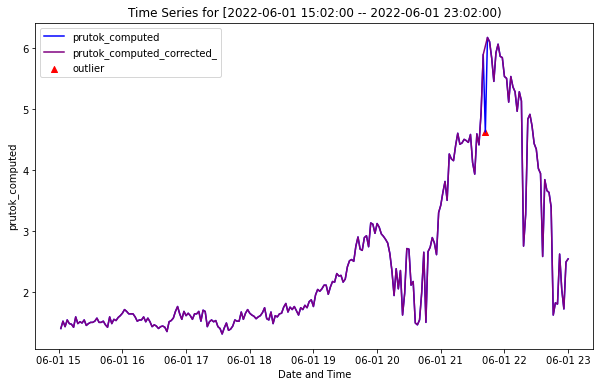

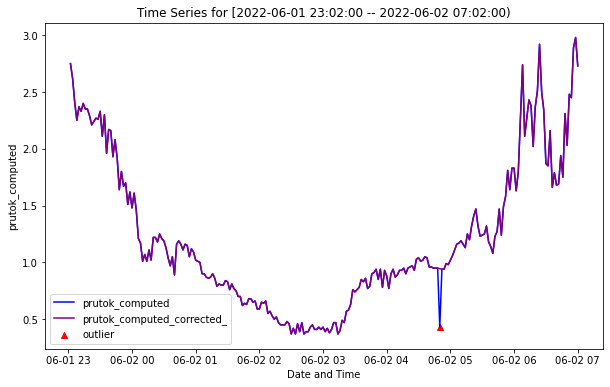

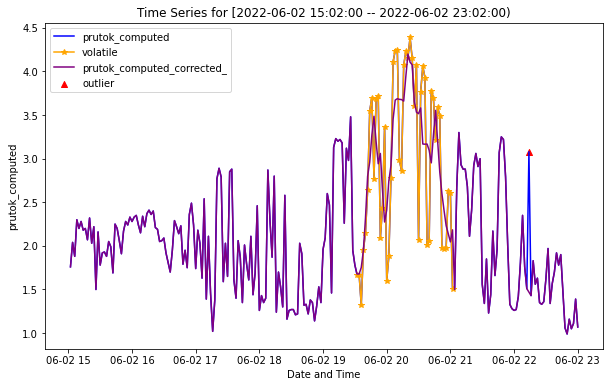

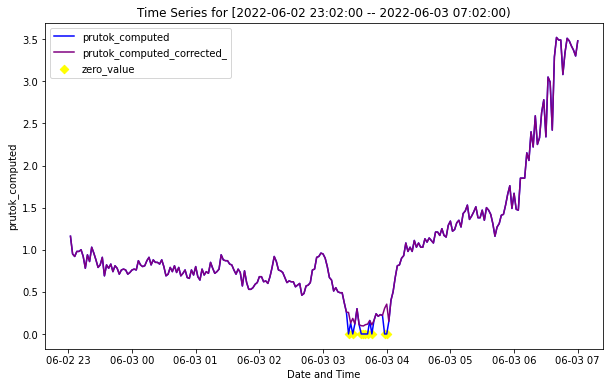

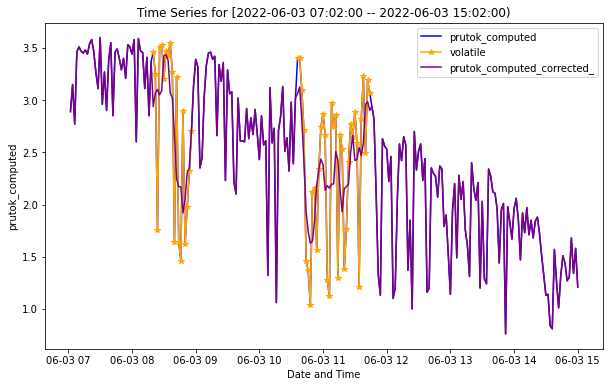

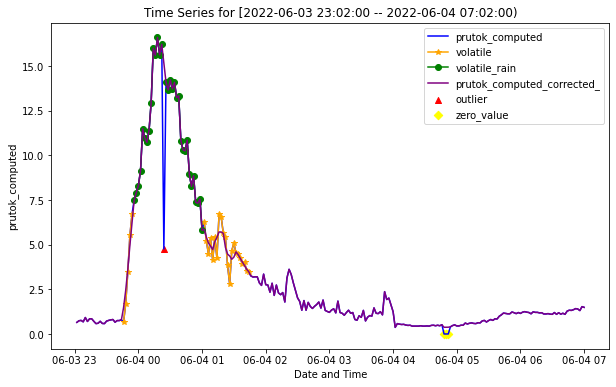

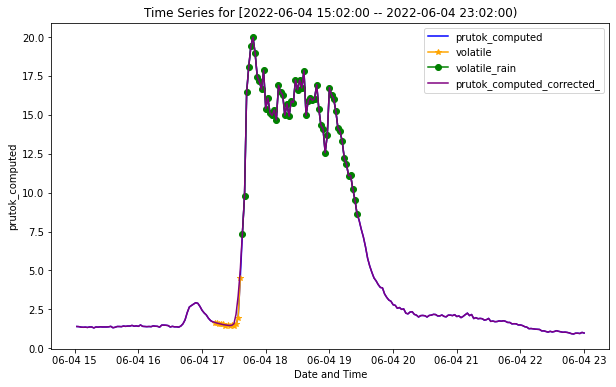

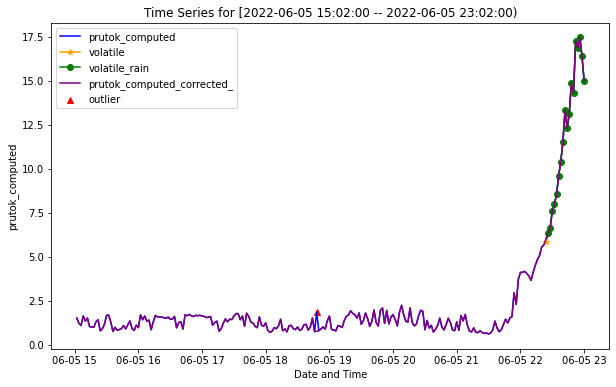

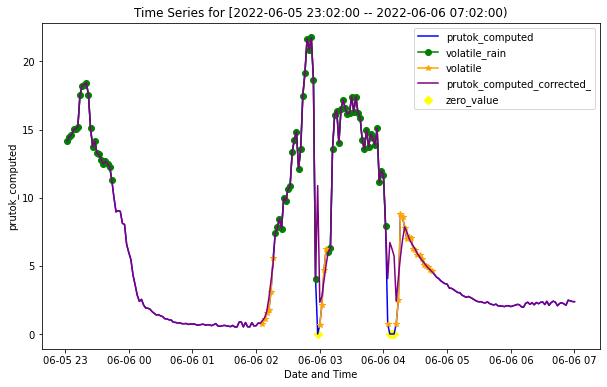

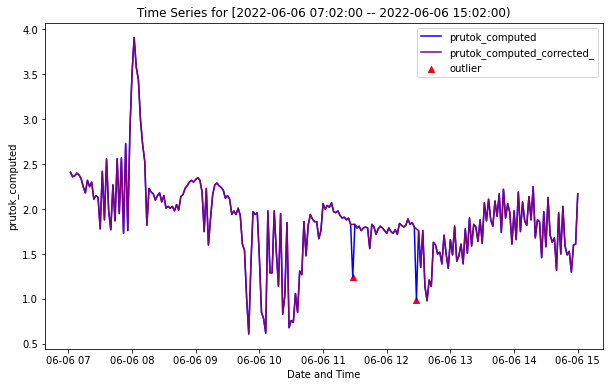

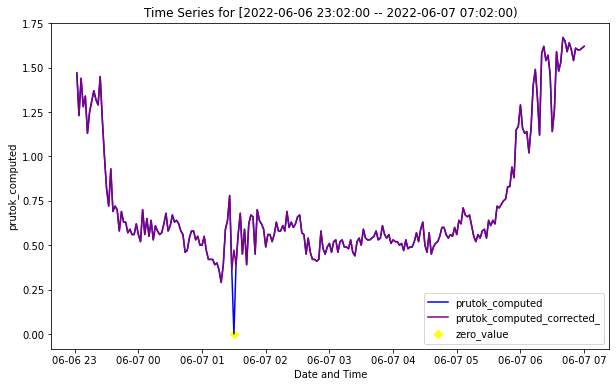

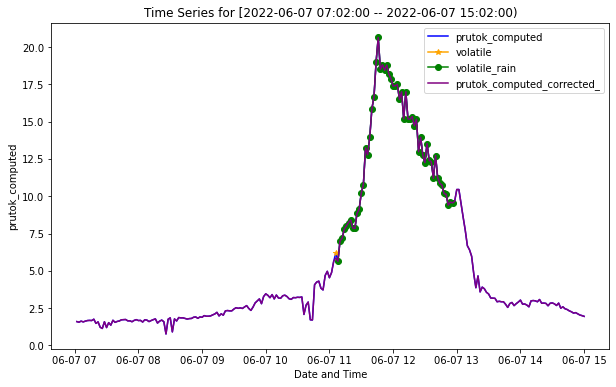

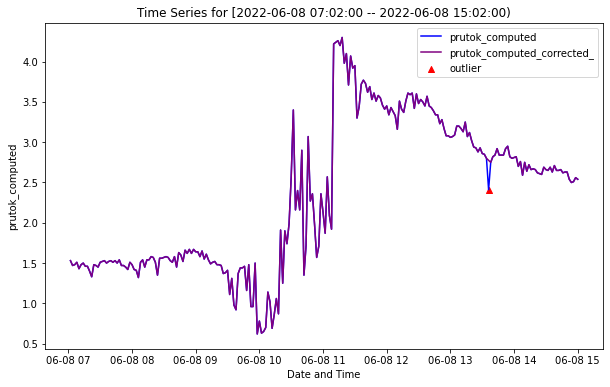

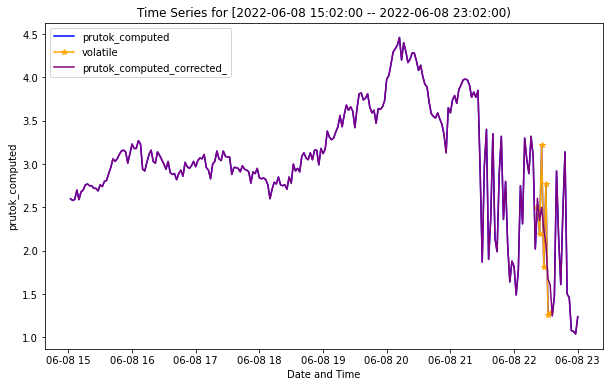

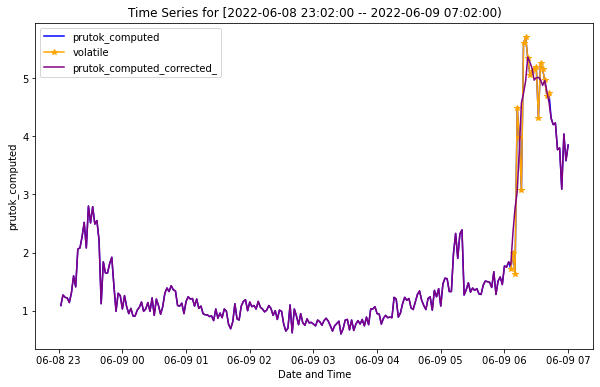

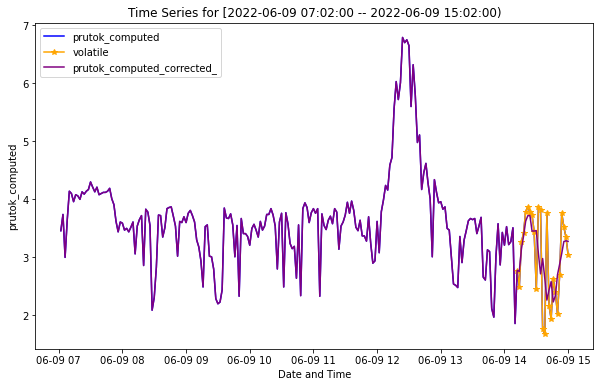

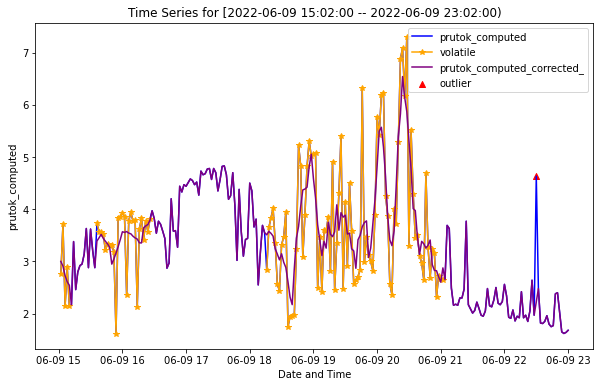

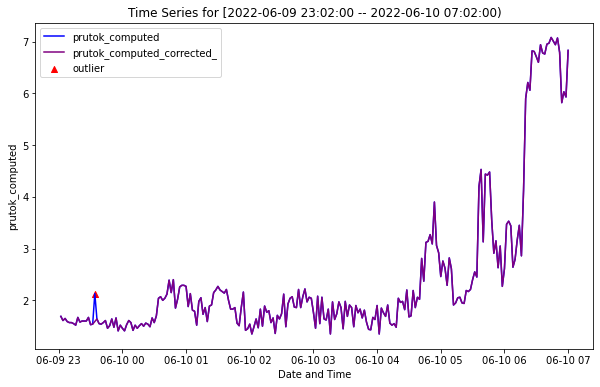

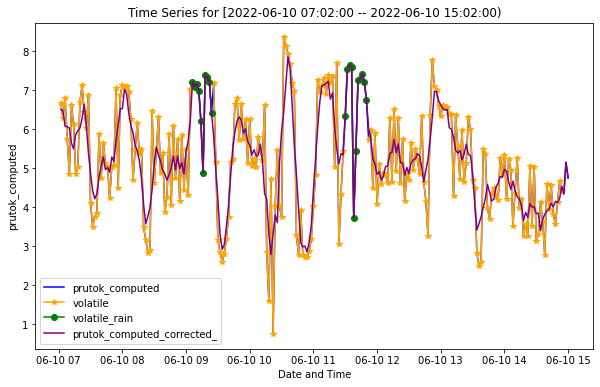

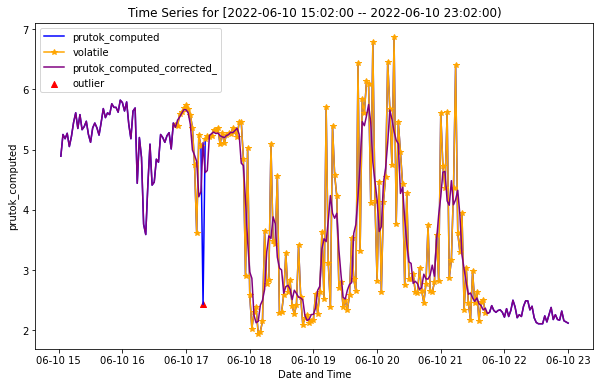

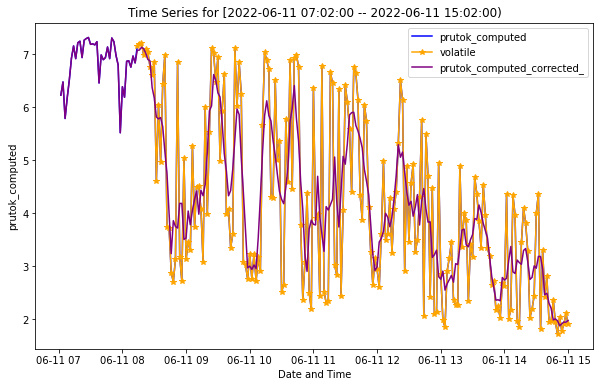

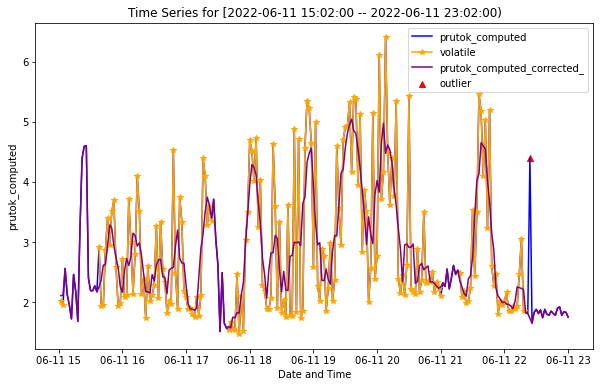

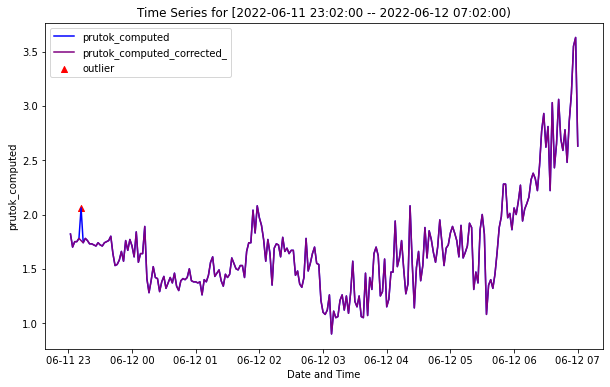

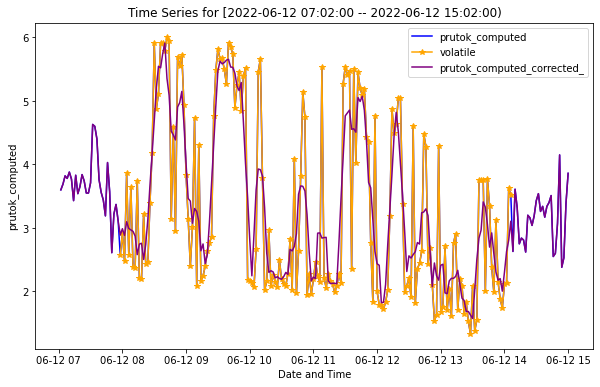

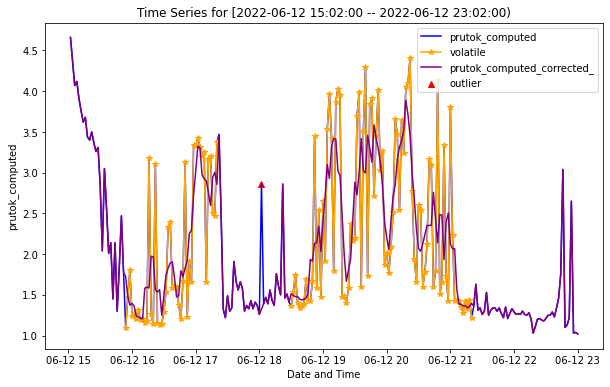

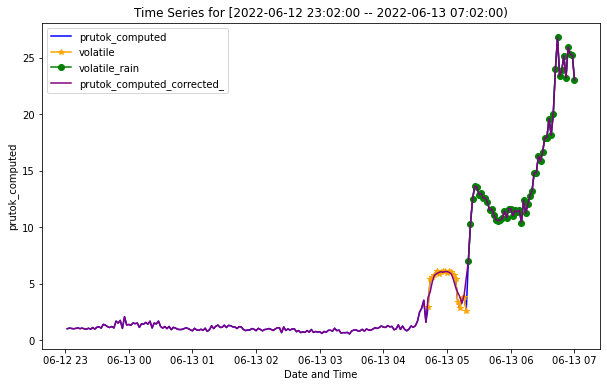

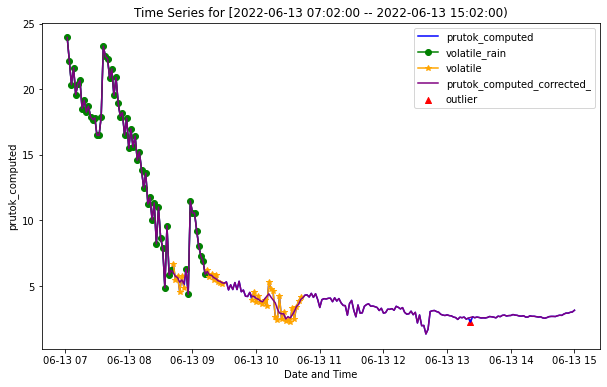

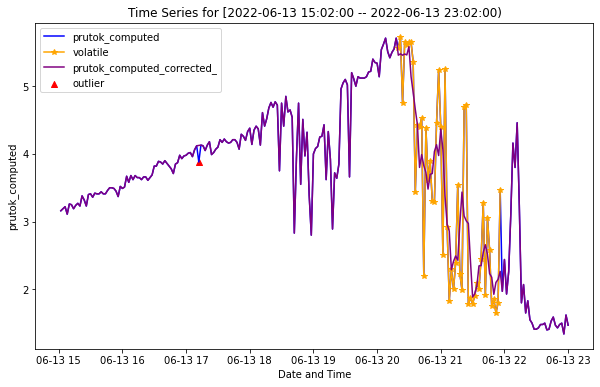

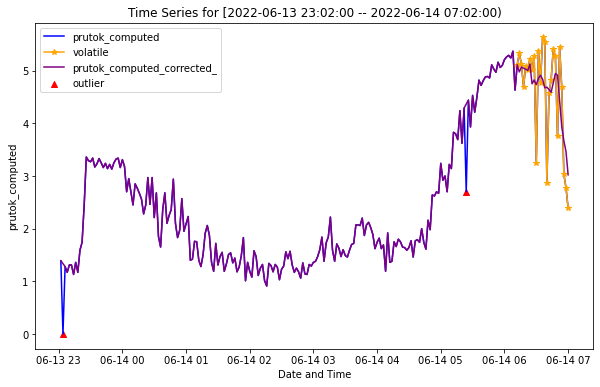

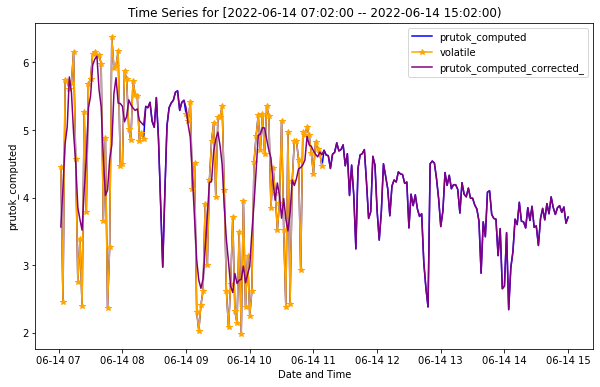

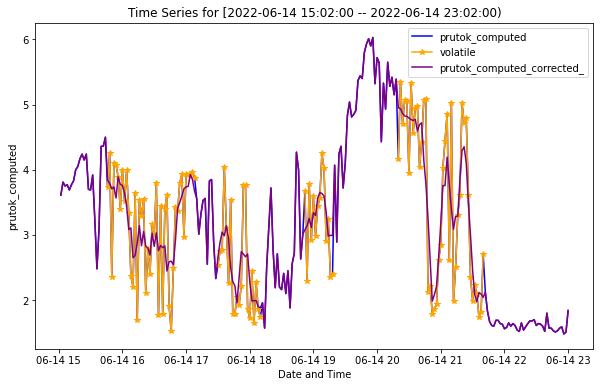

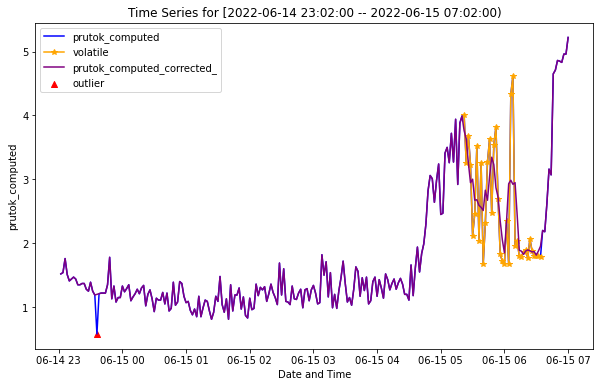

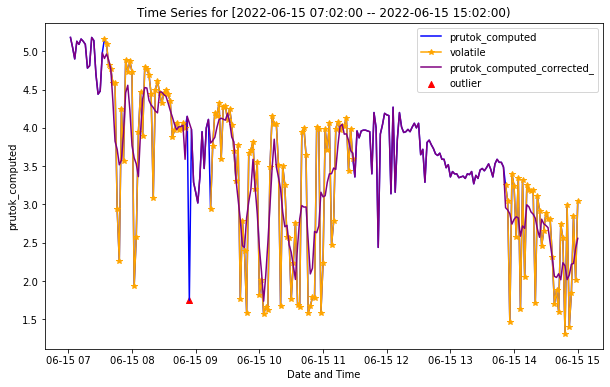

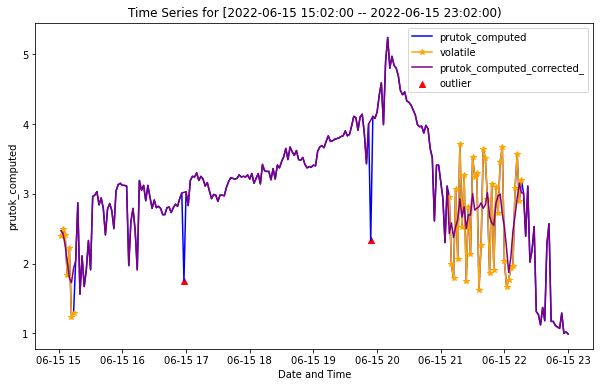

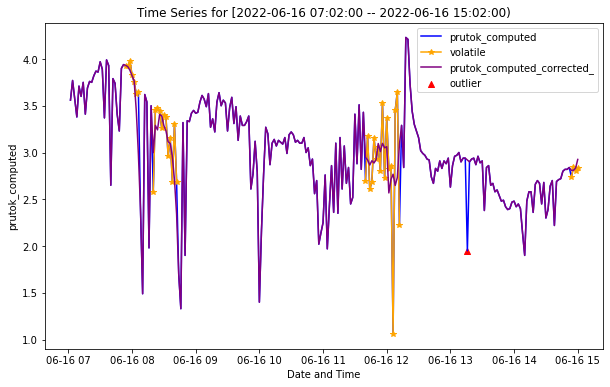

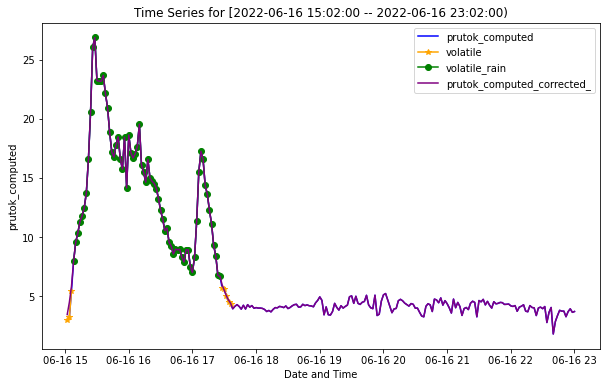

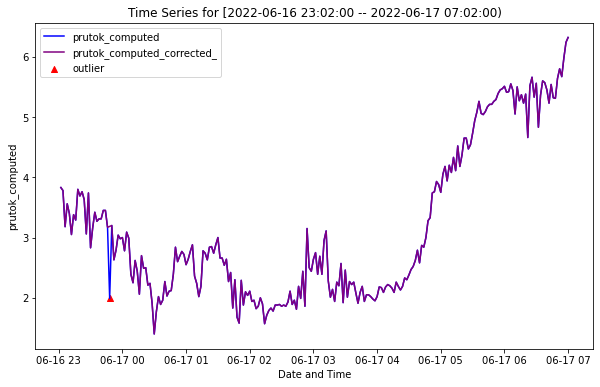

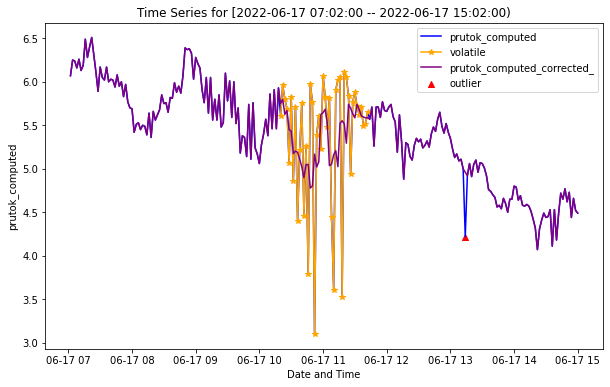

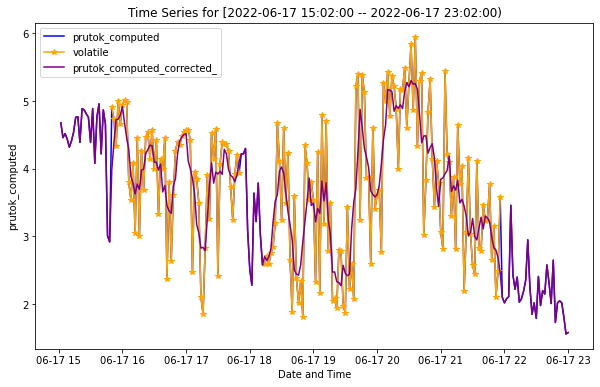

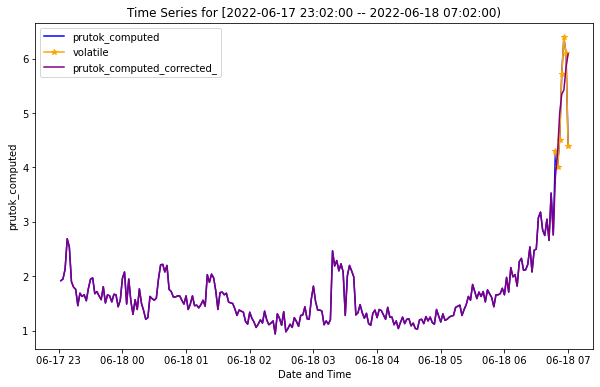

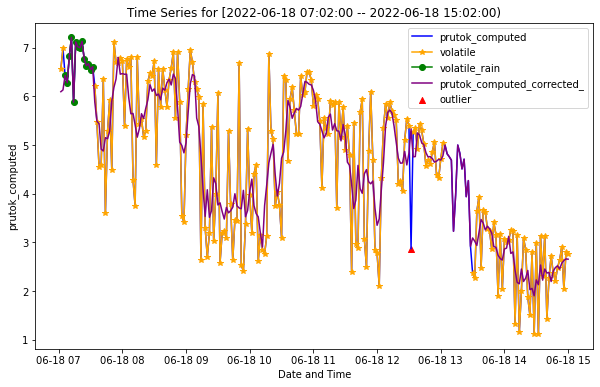

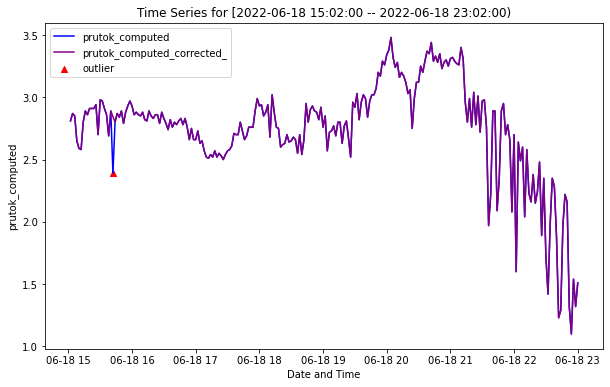

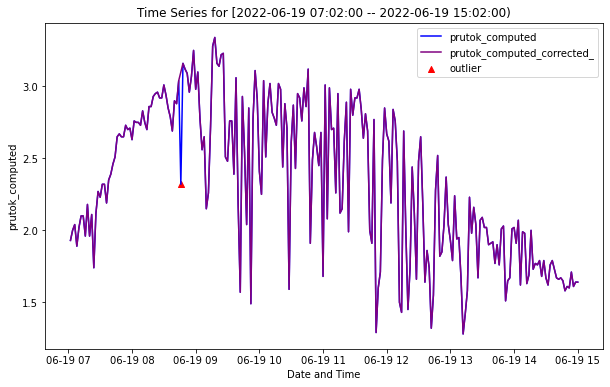

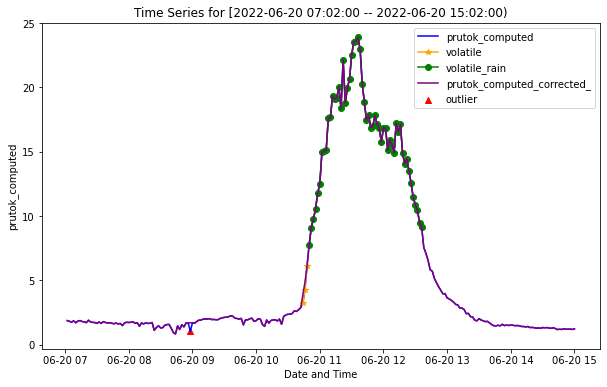

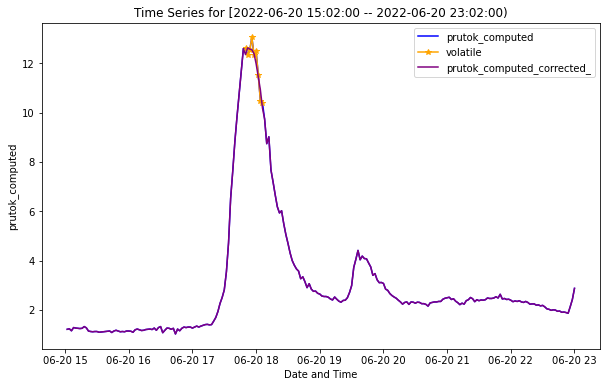

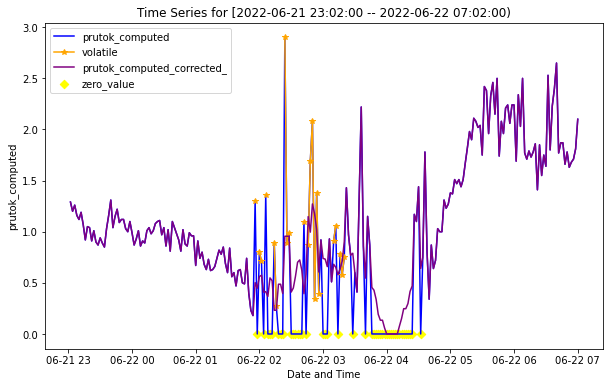

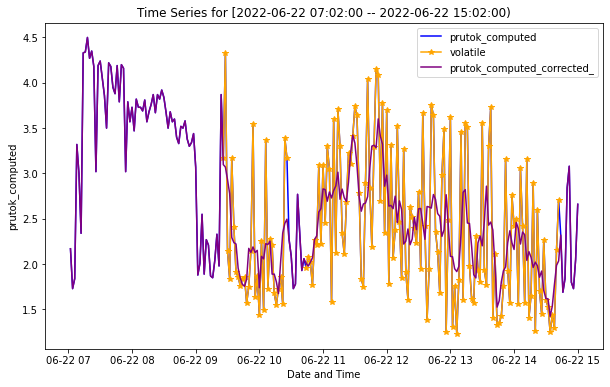

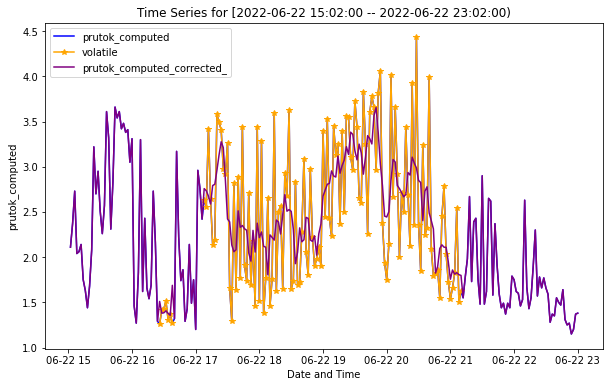

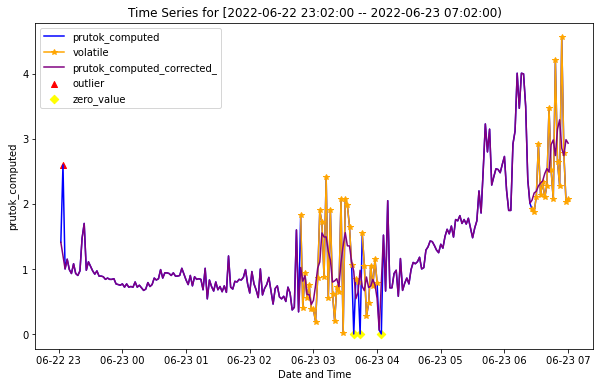

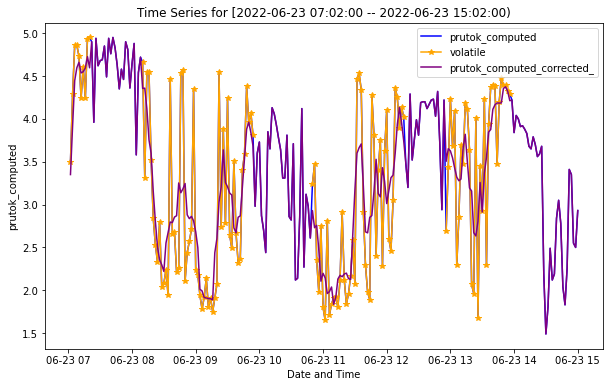

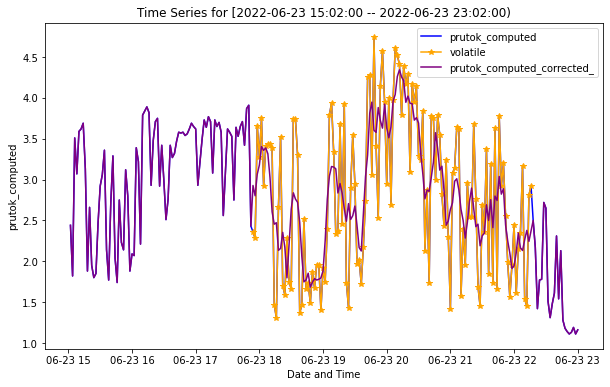

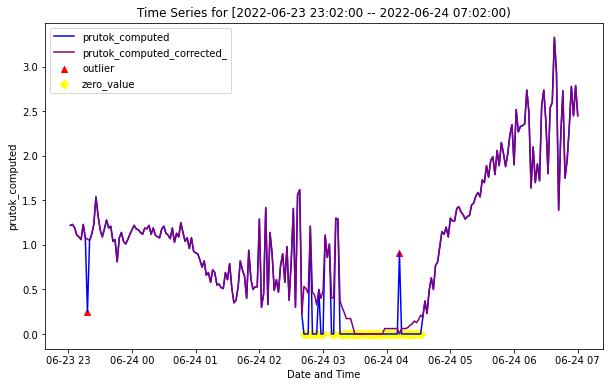

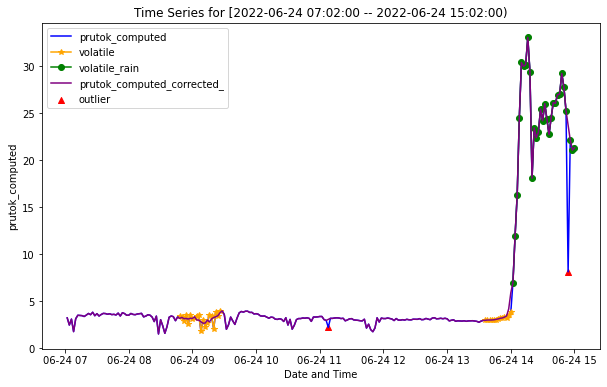

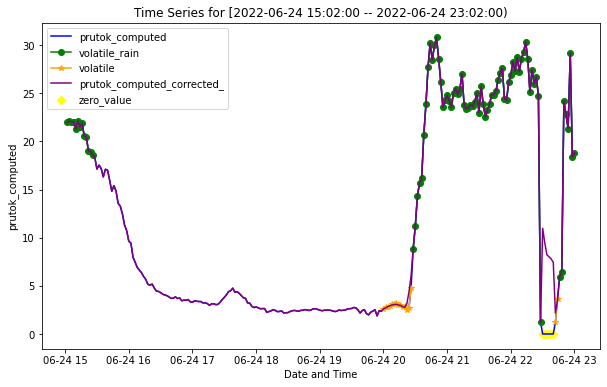

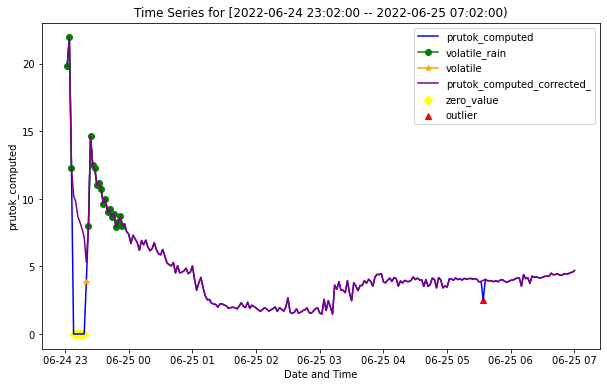

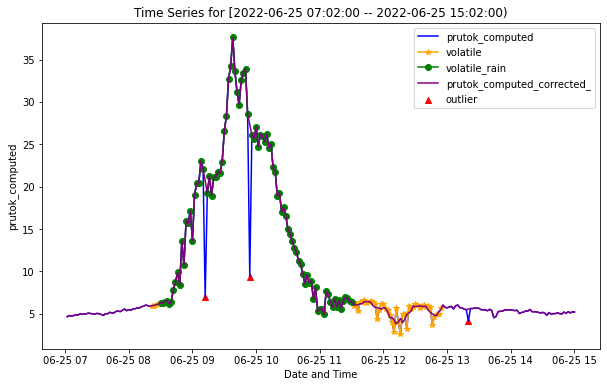

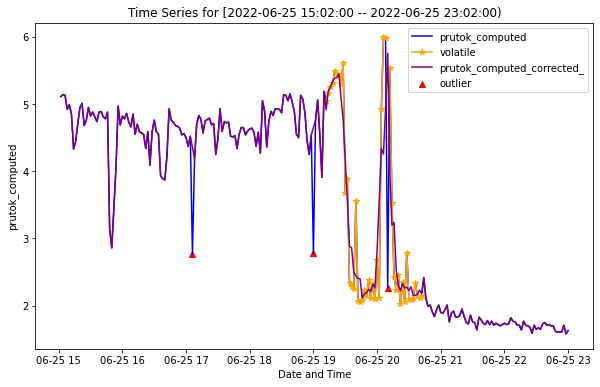

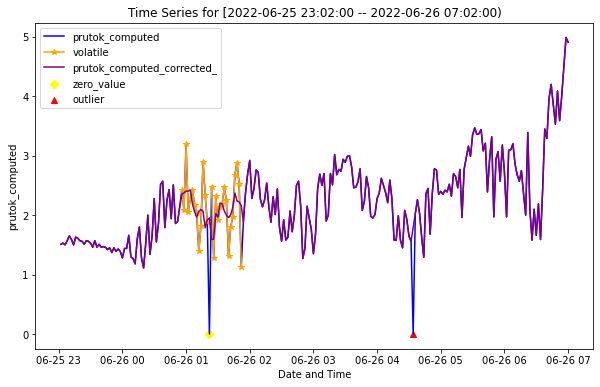

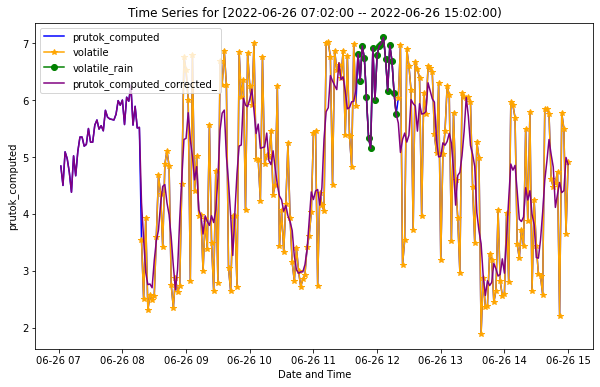

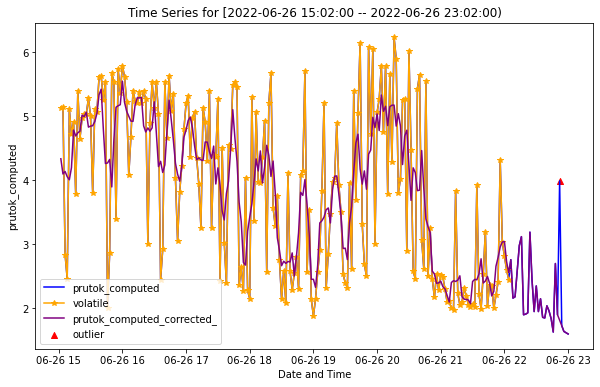

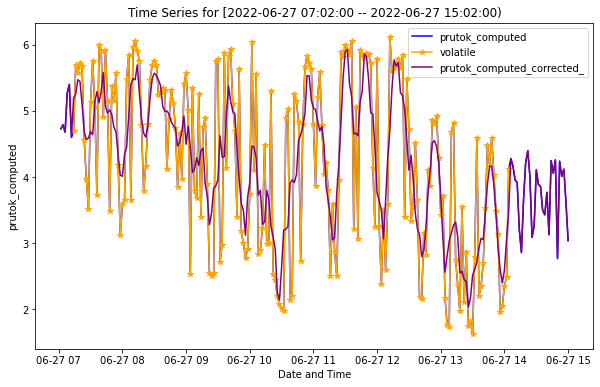

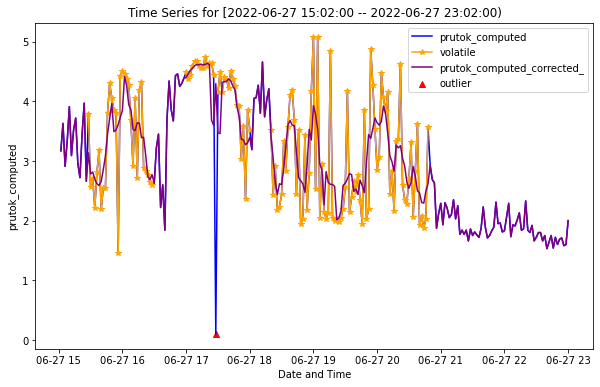

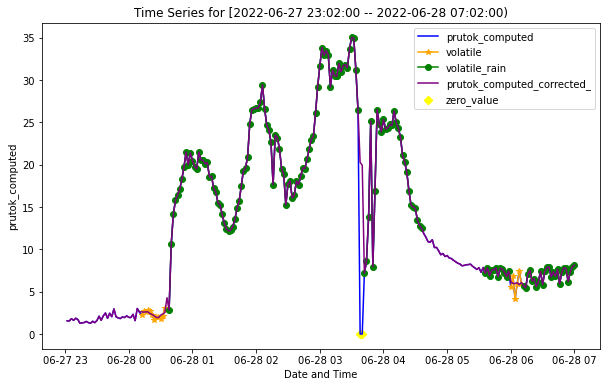

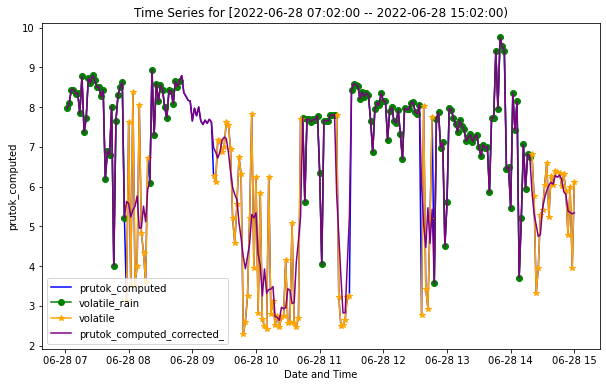

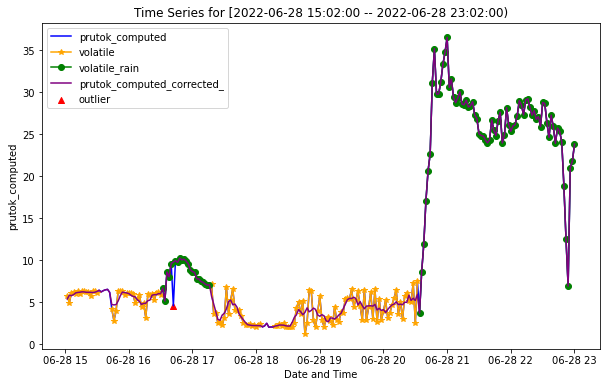

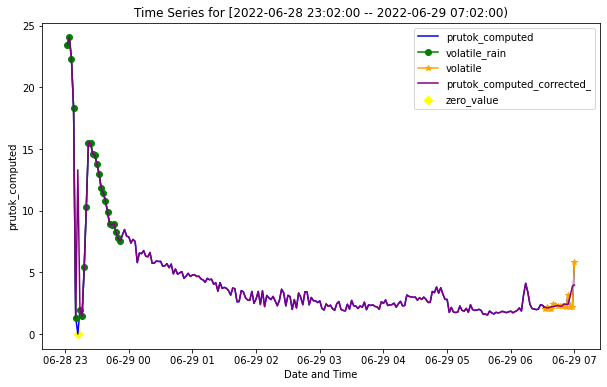

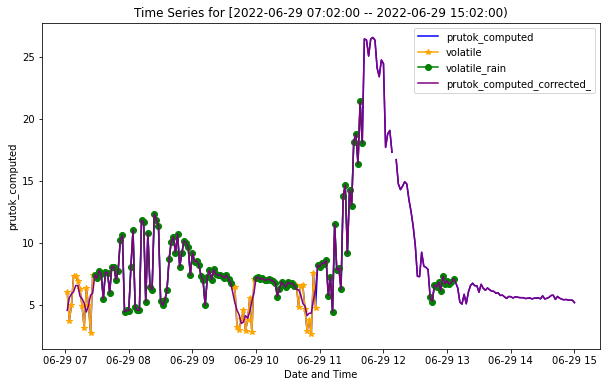

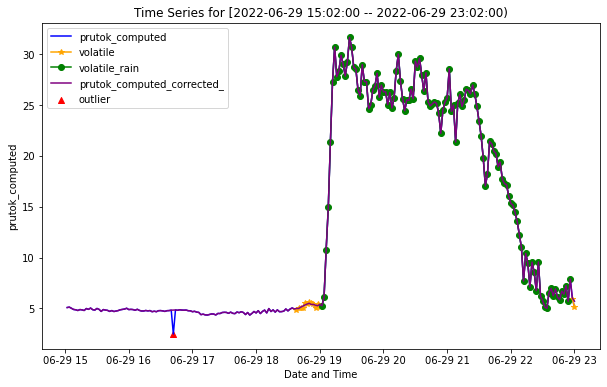

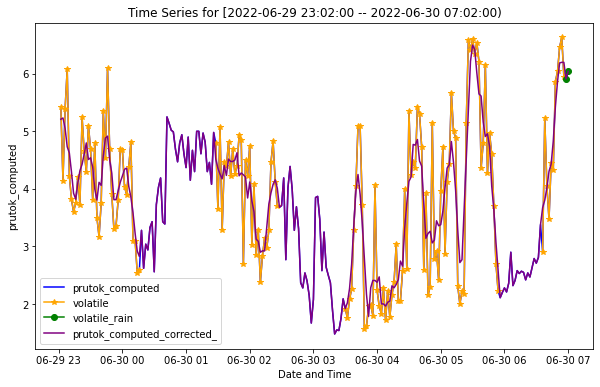

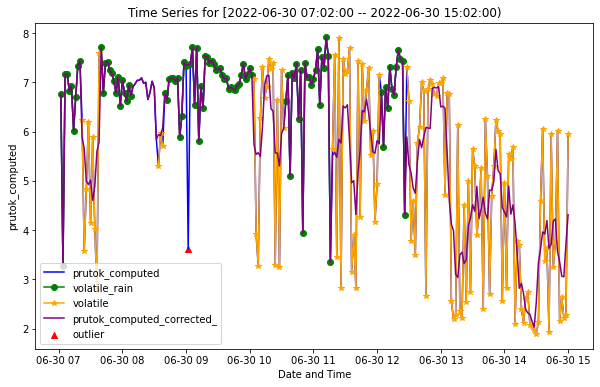

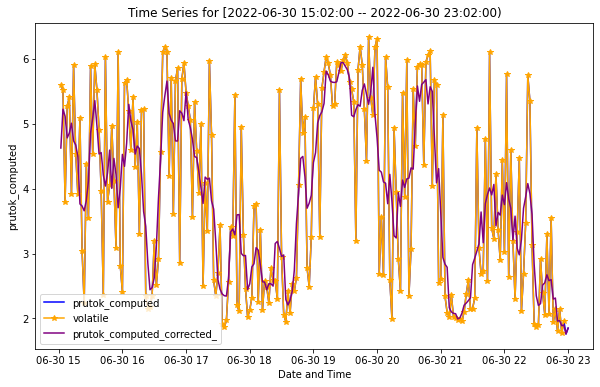

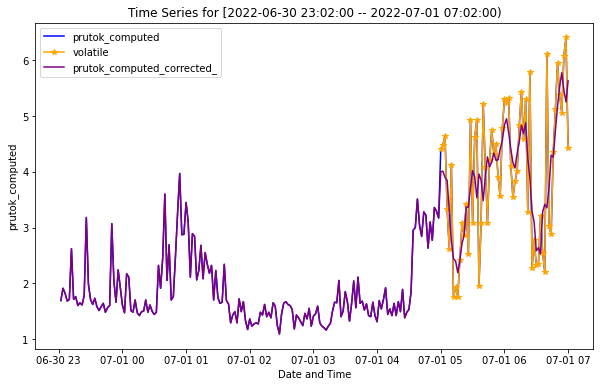

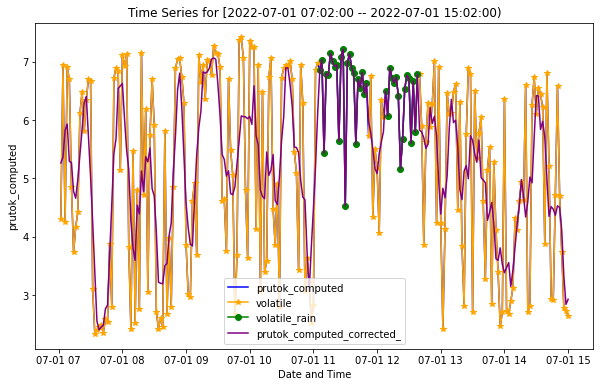

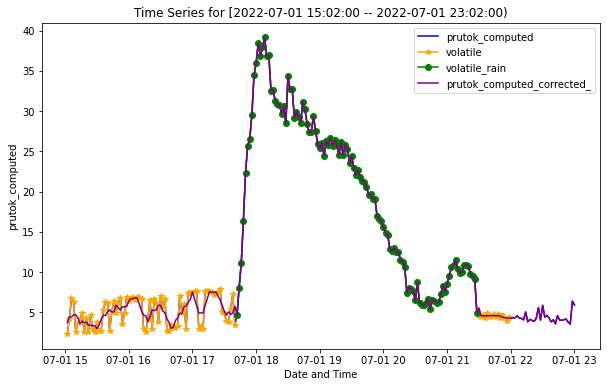

In [219]:
ee.plot_categories(period=8, corrections=ee.main_var+"_corrected_")  # 2.6. and 3-4.6.2022 for vol correction example
# 3.6. for zero value correction
# 6.6.2022 example of persistent outlier

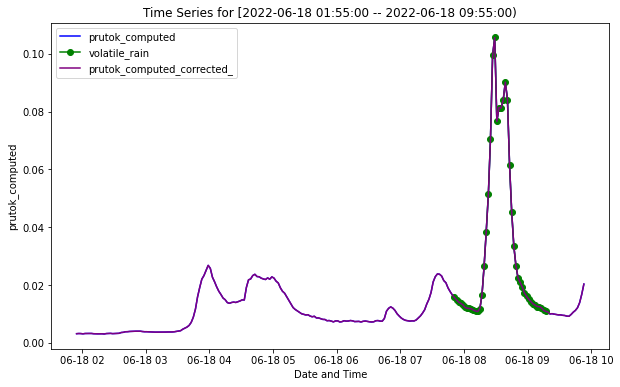

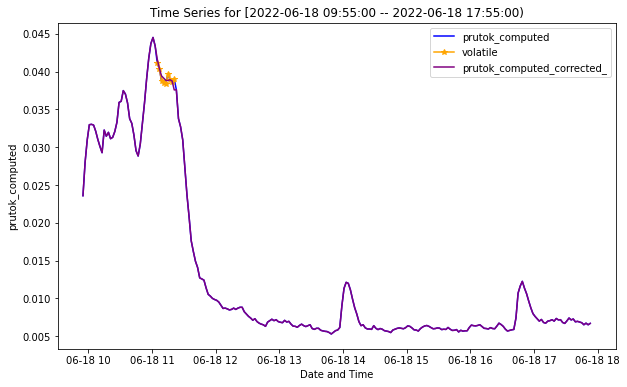

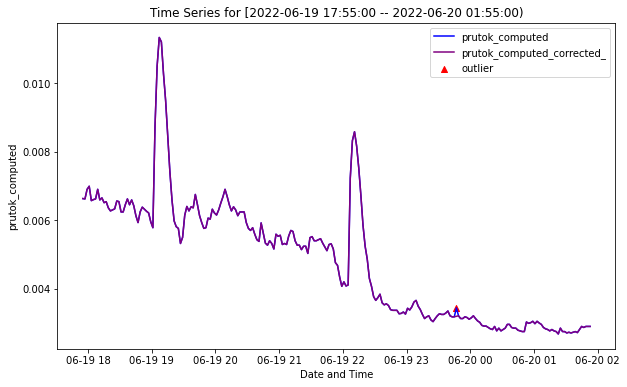

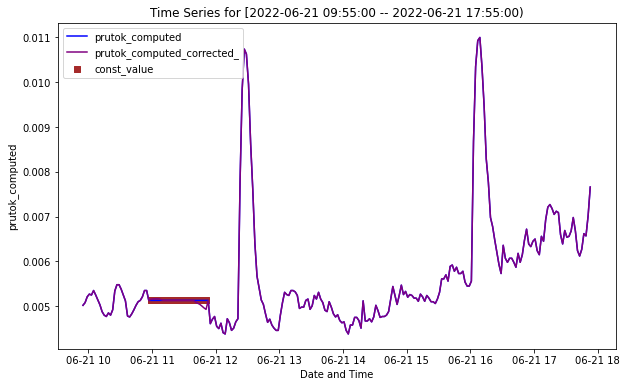

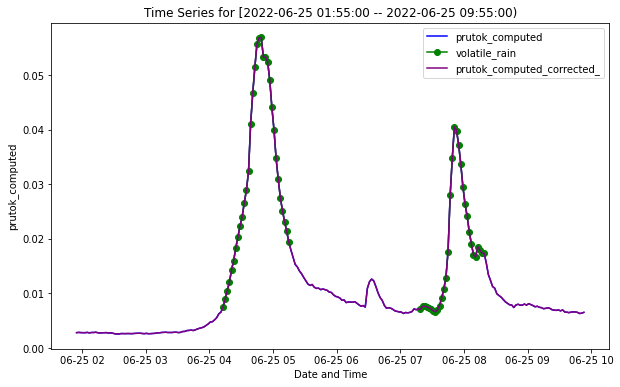

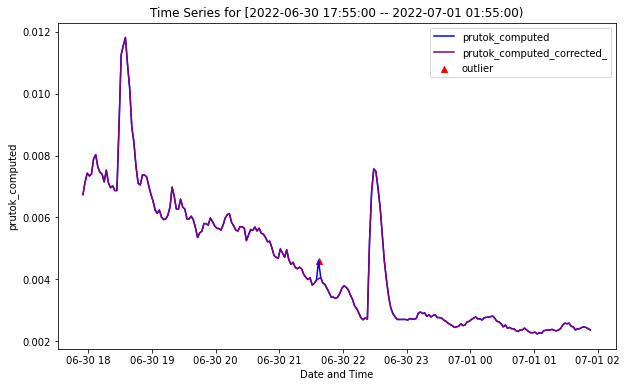

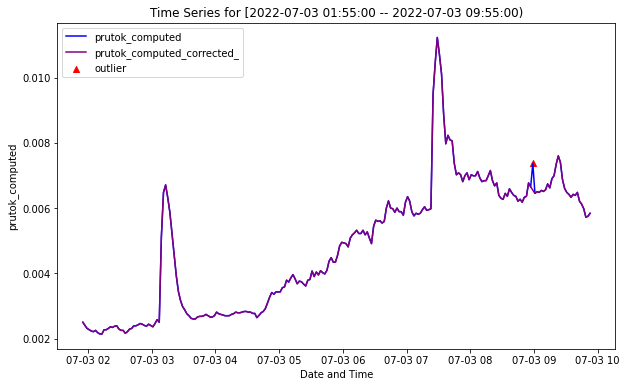

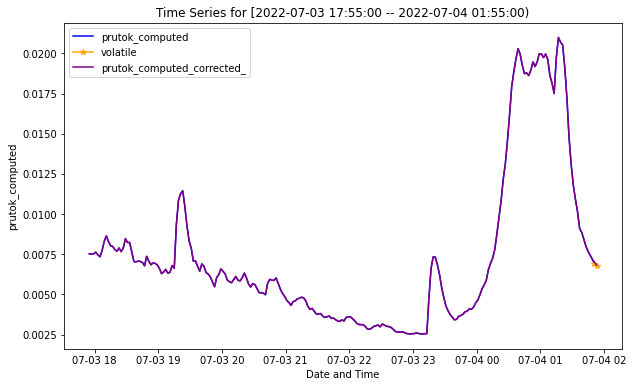

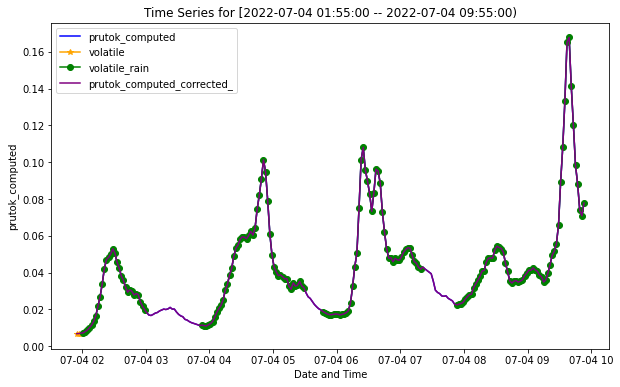

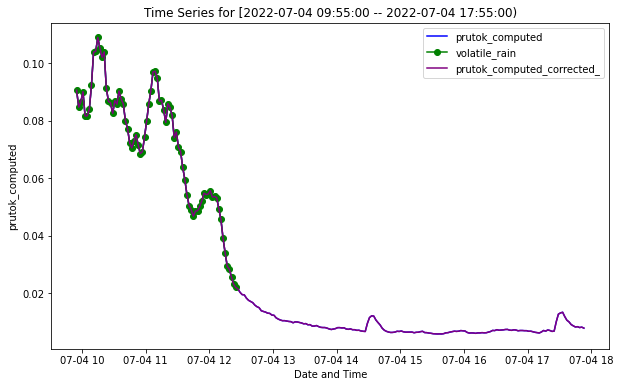

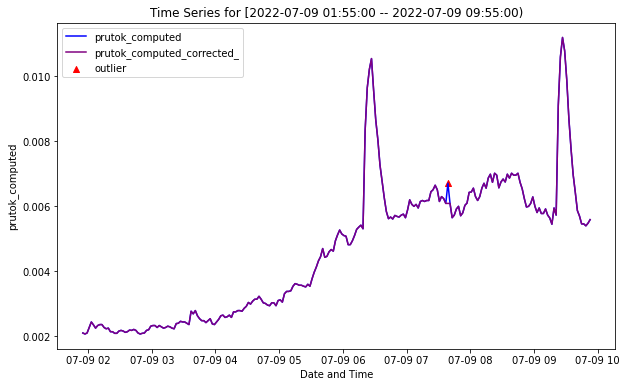

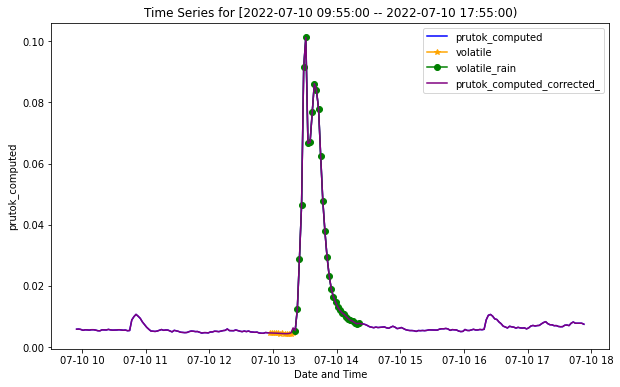

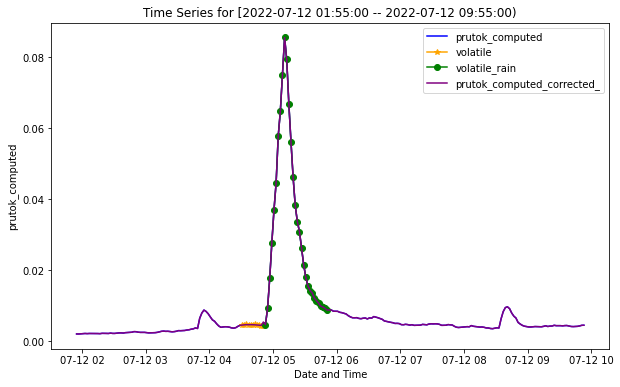

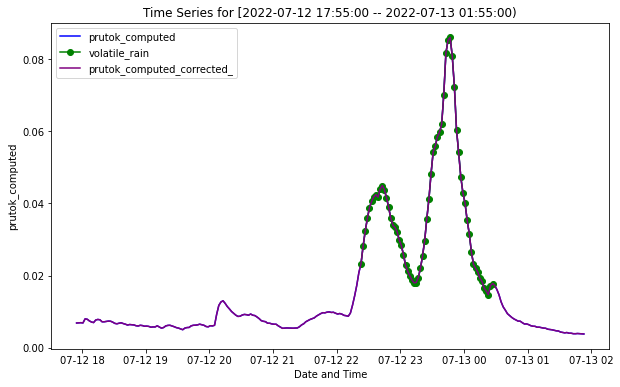

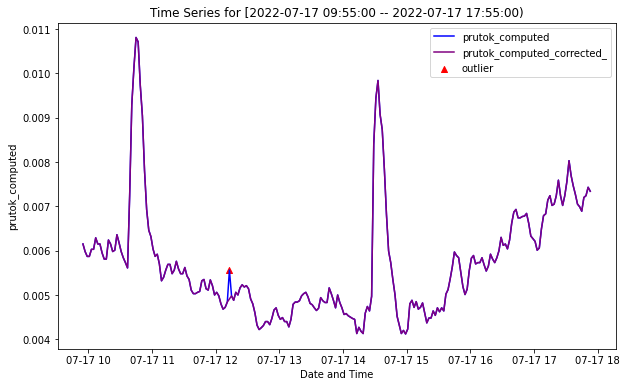

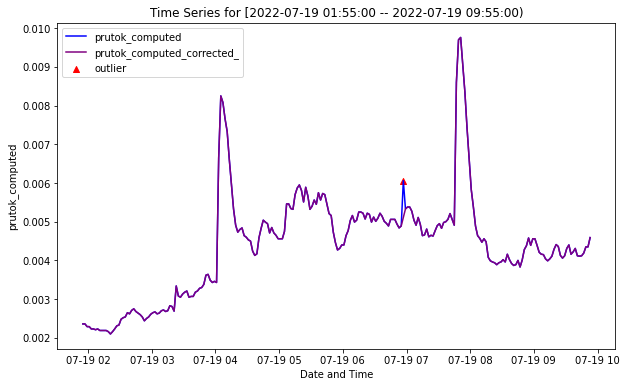

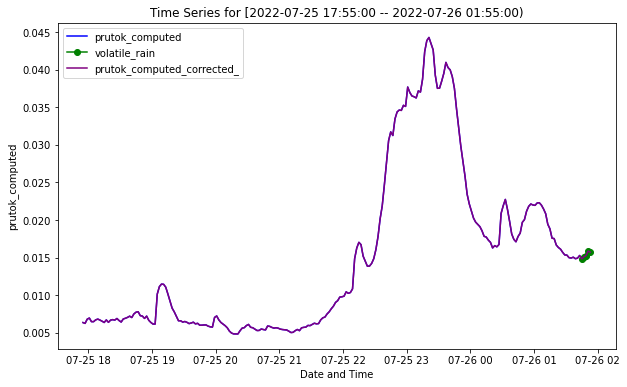

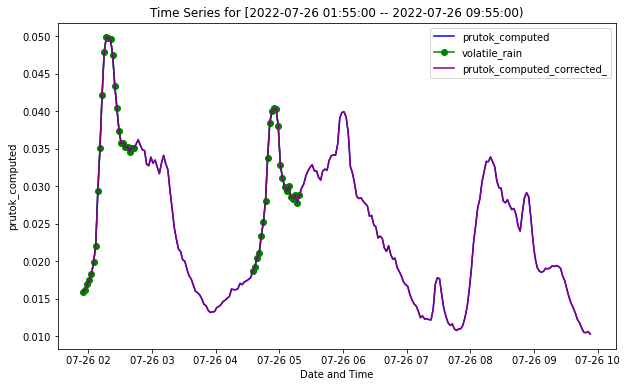

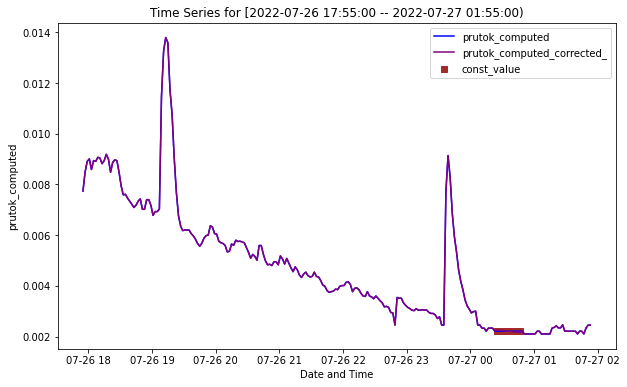

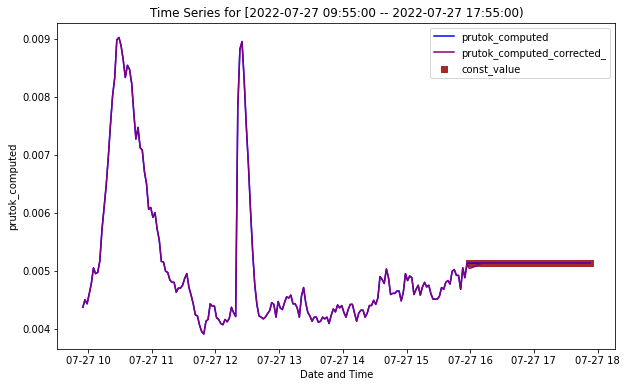

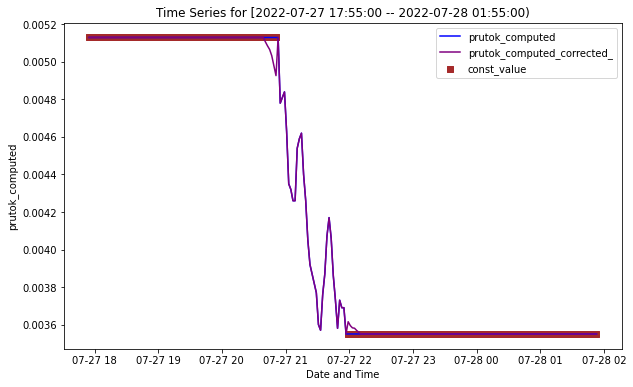

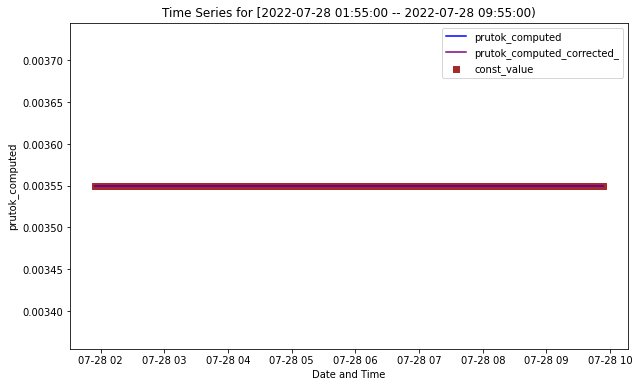

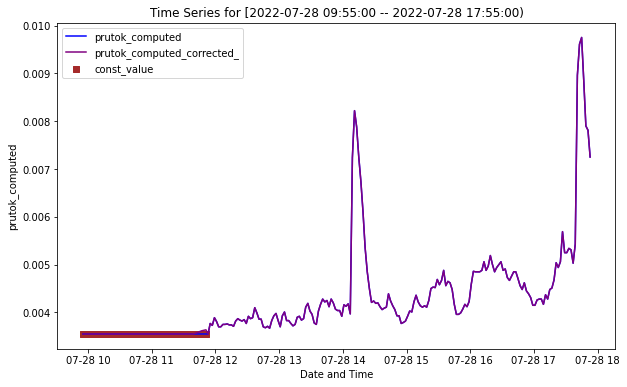

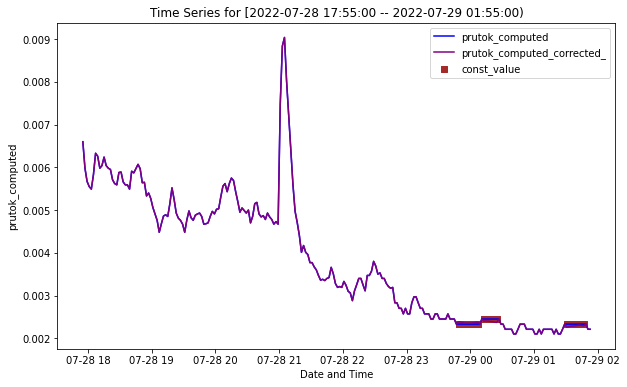

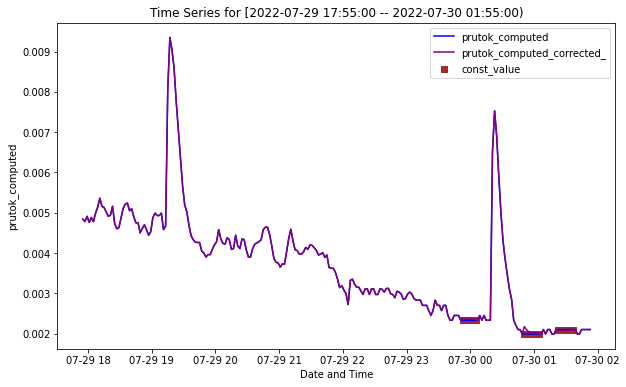

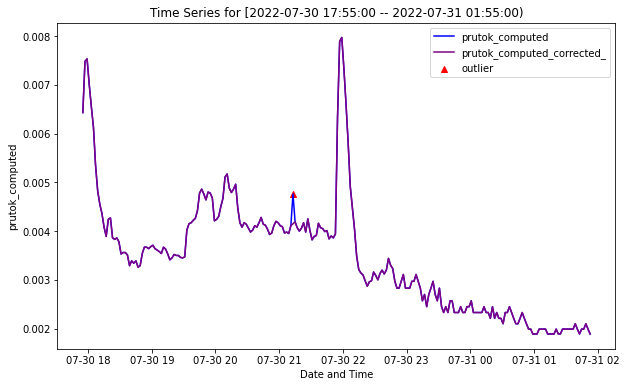

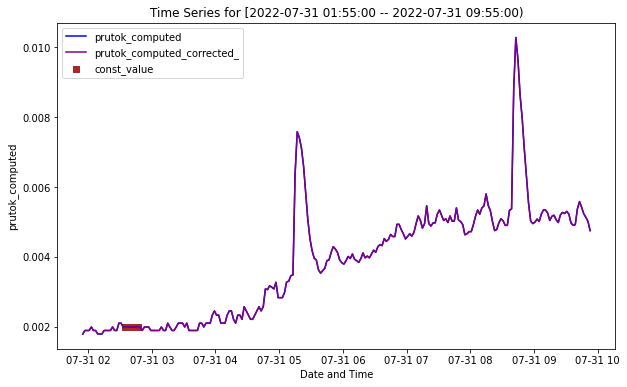

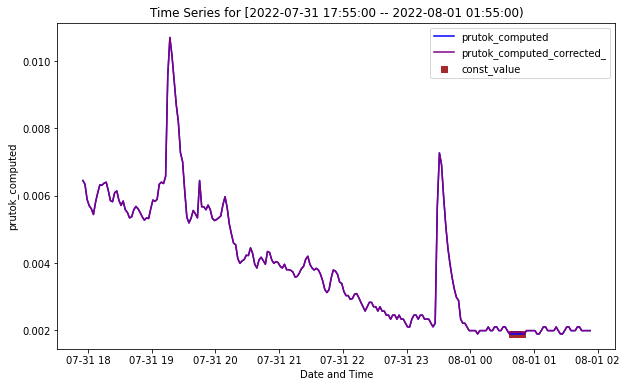

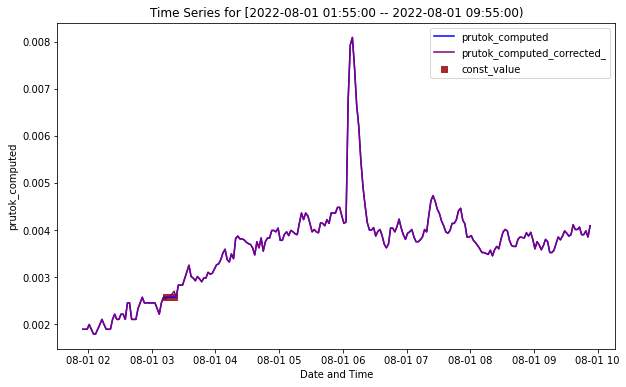

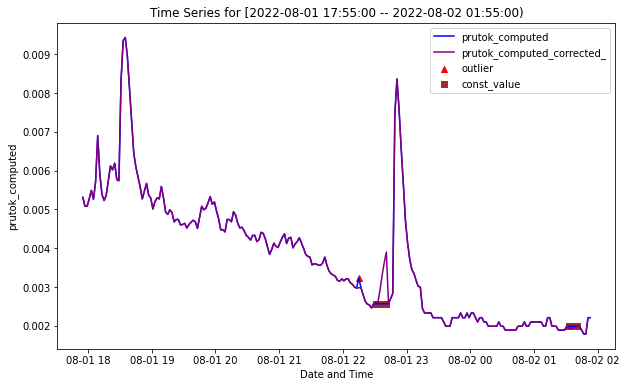

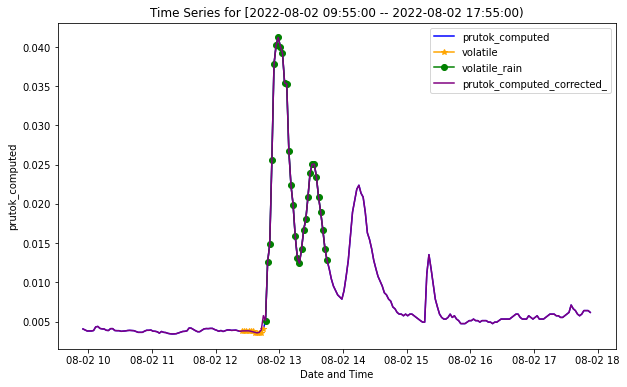

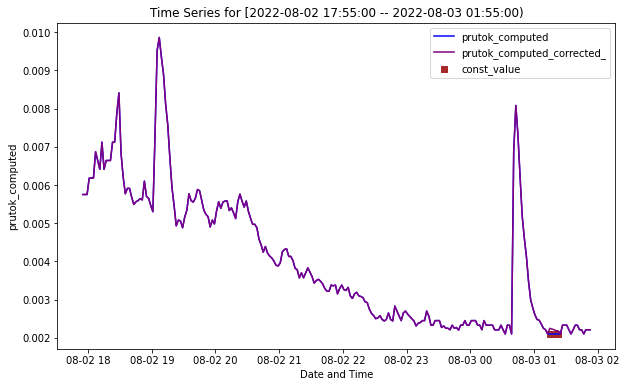

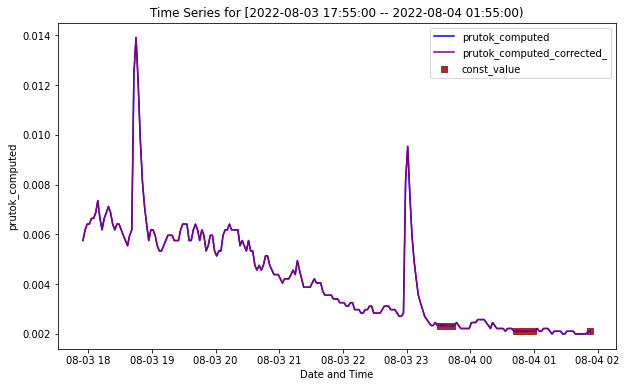

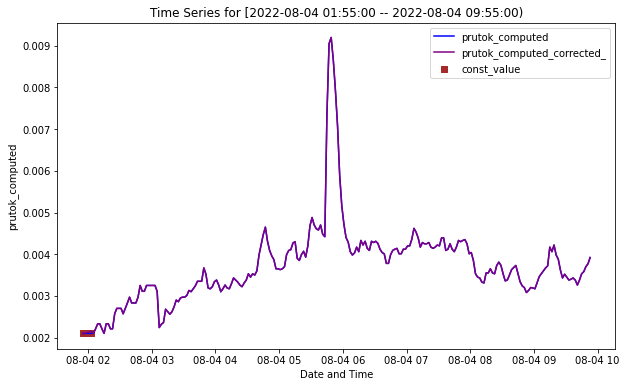

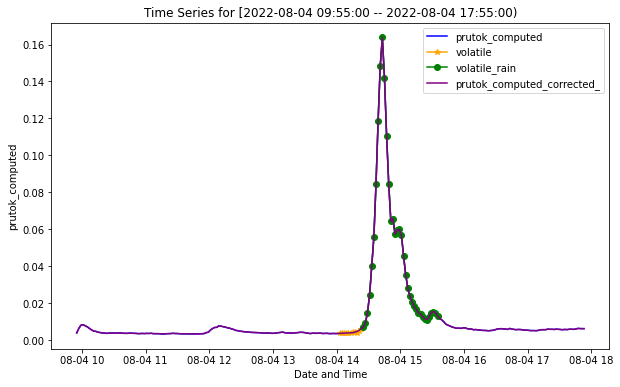

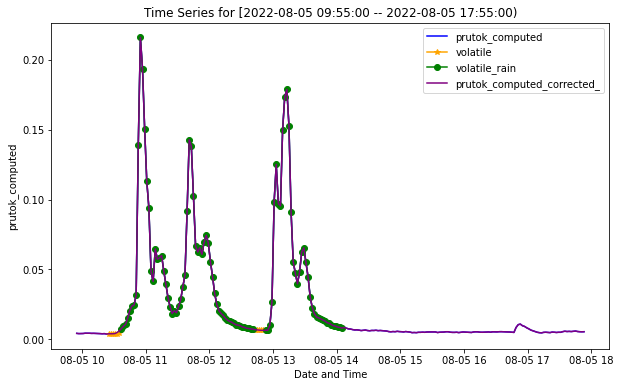

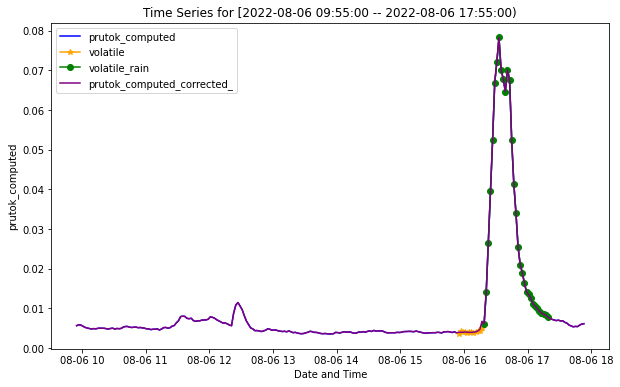

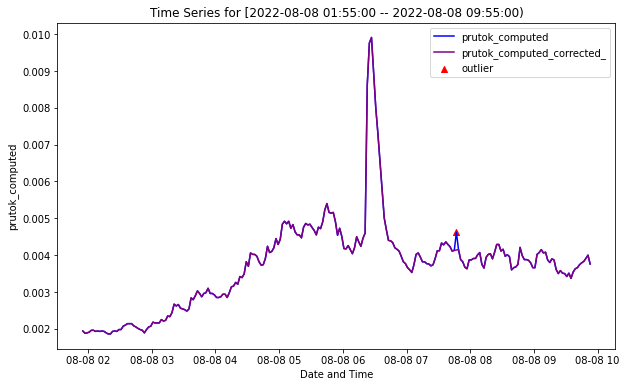

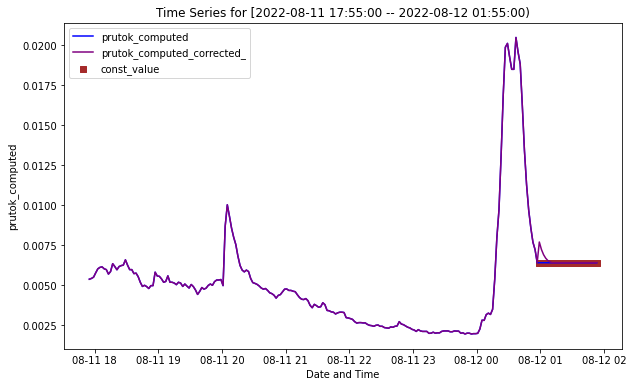

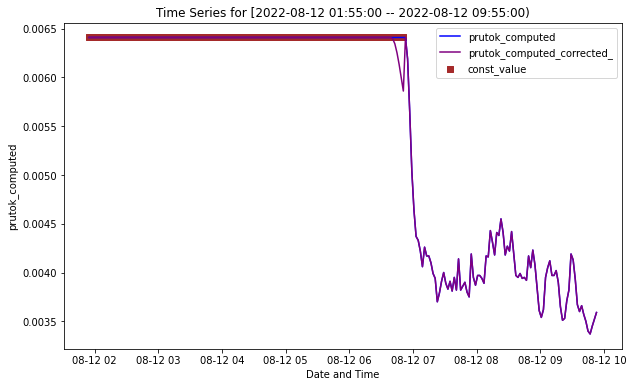

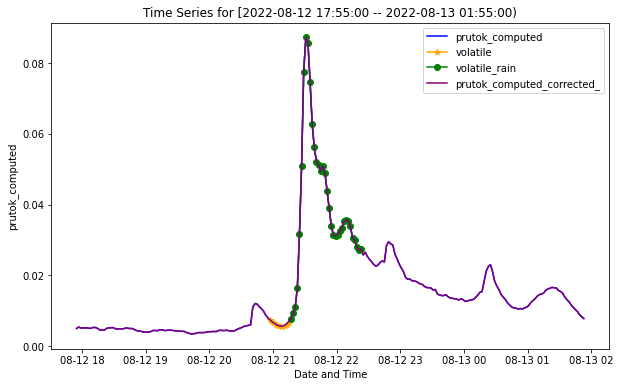

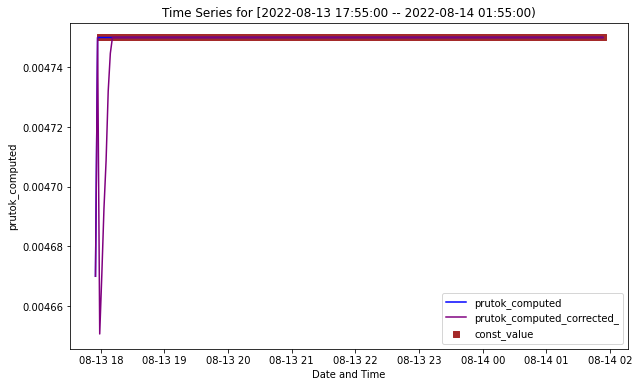

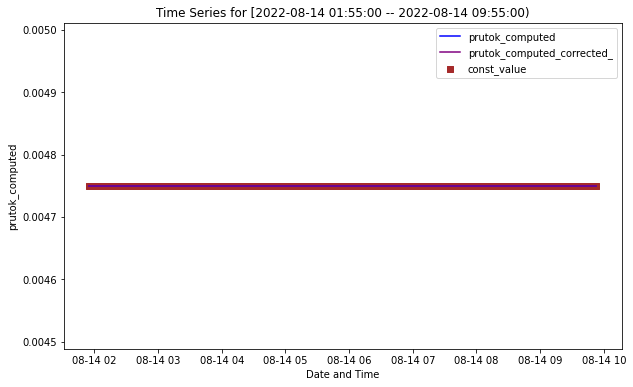

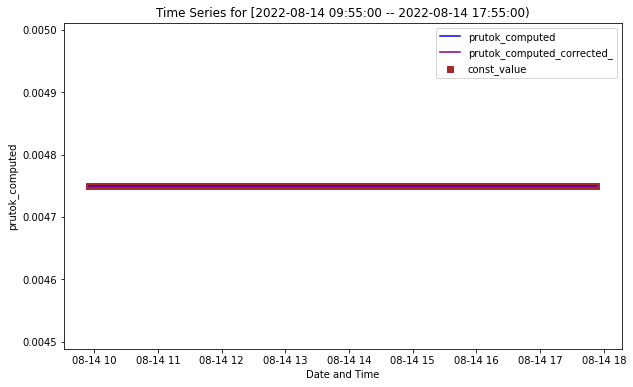

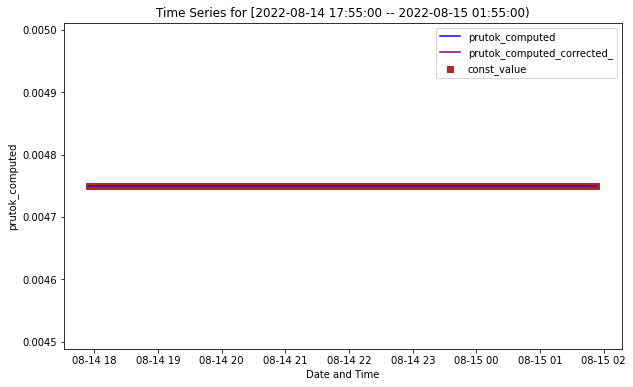

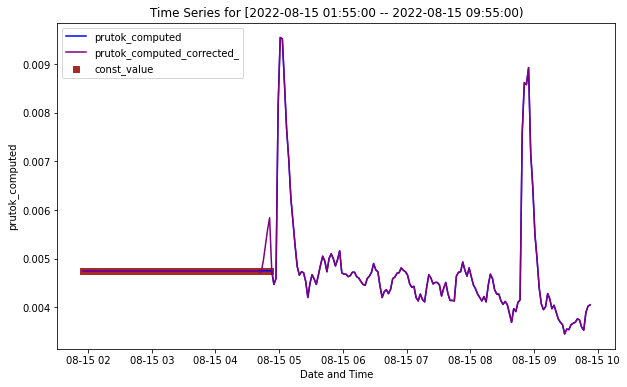

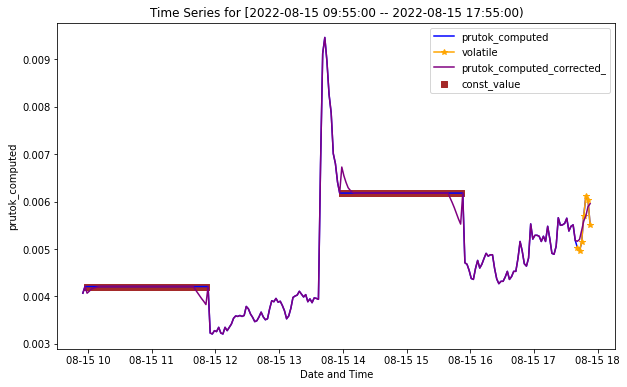

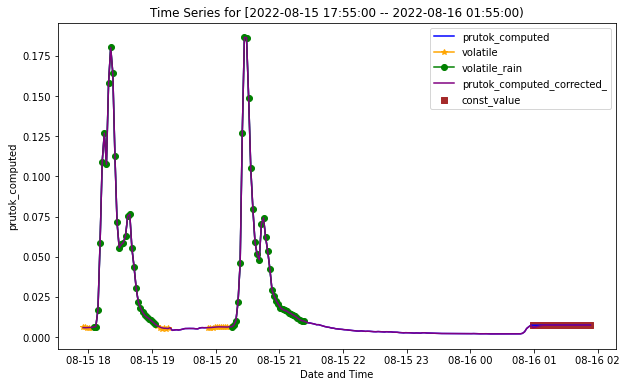

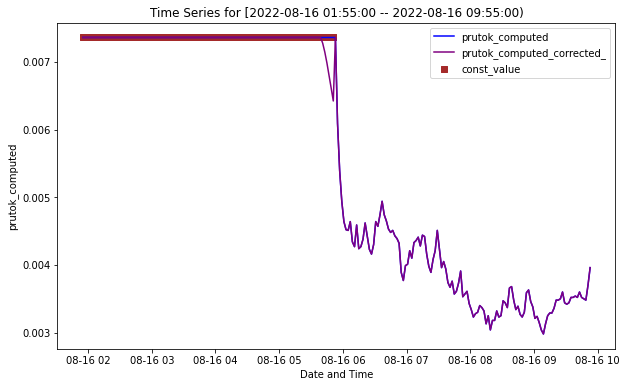

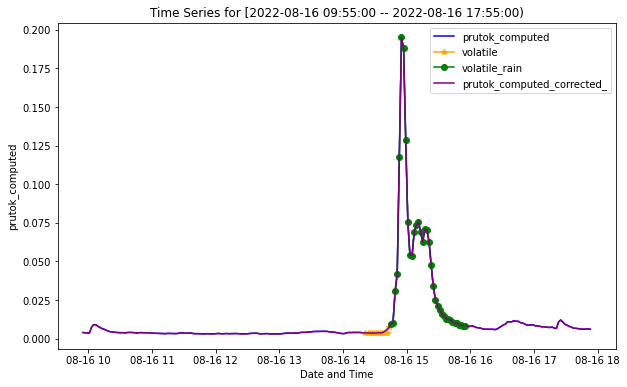

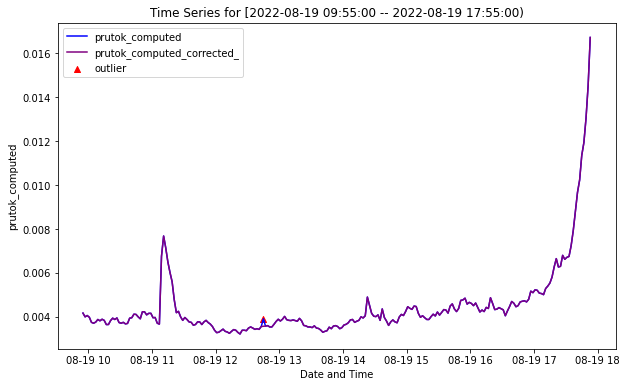

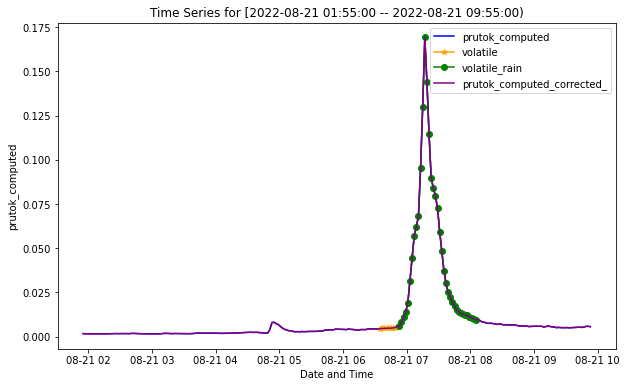

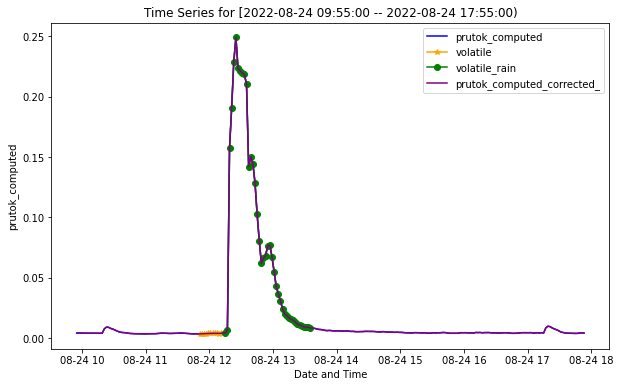

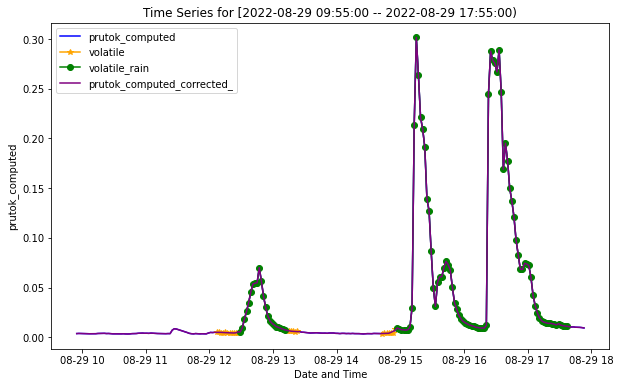

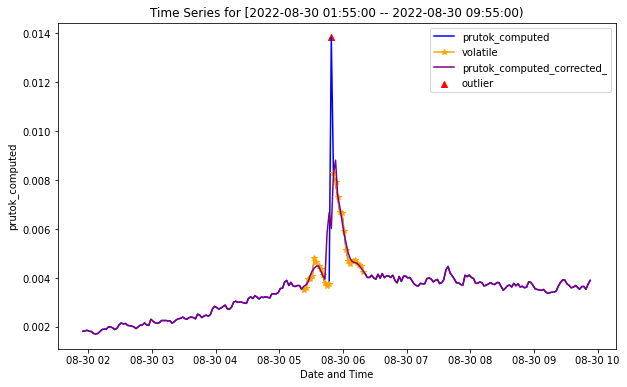

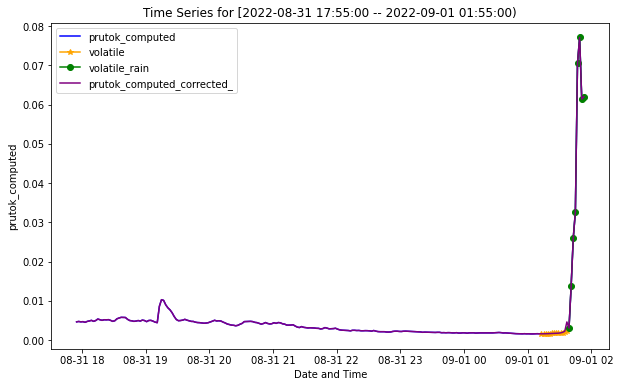

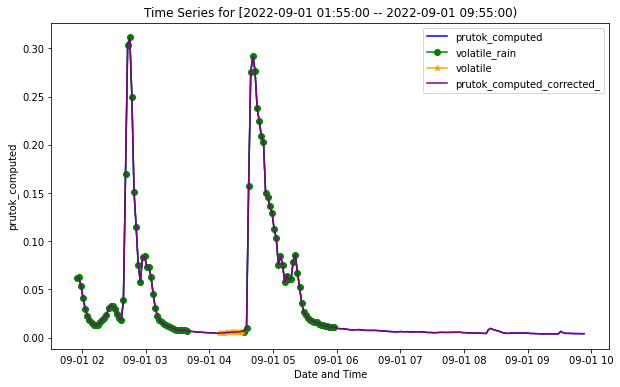

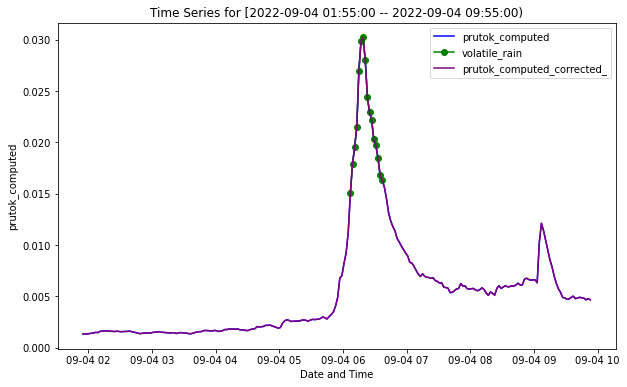

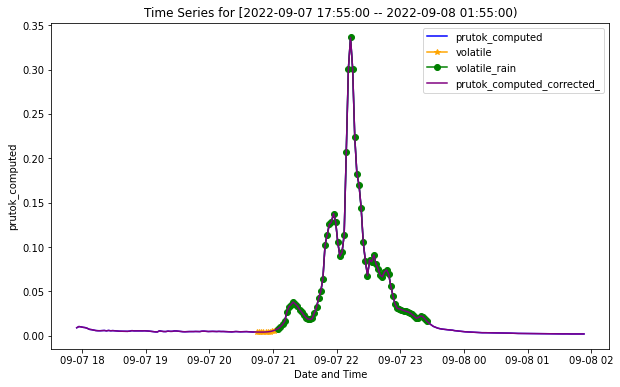

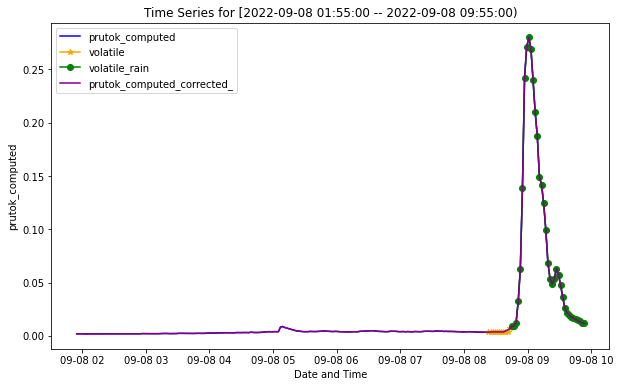

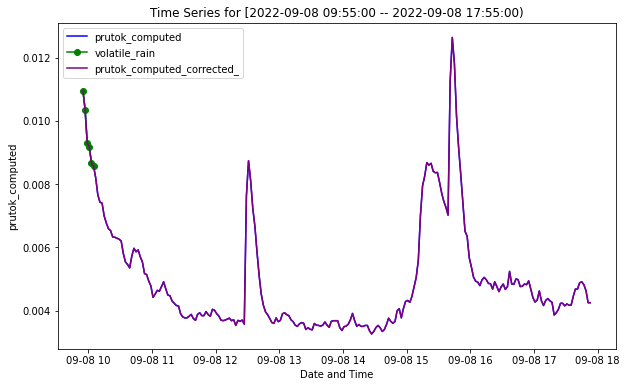

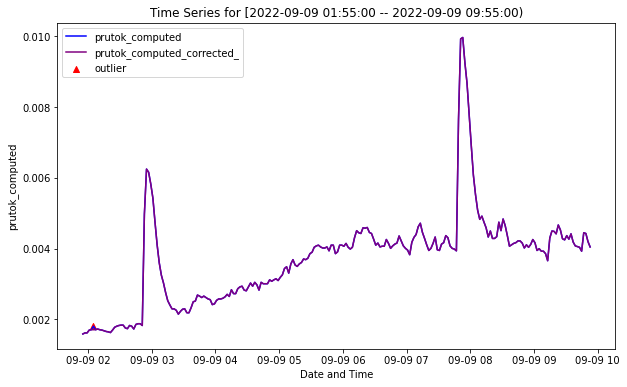

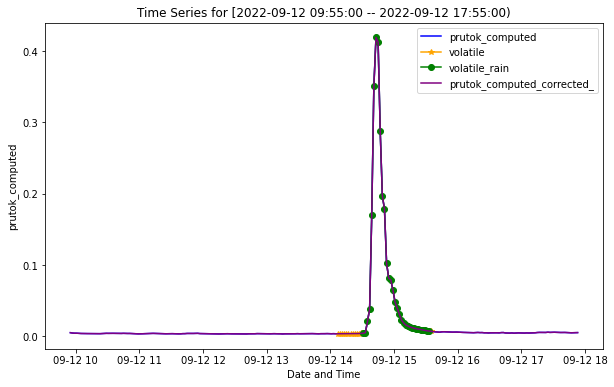

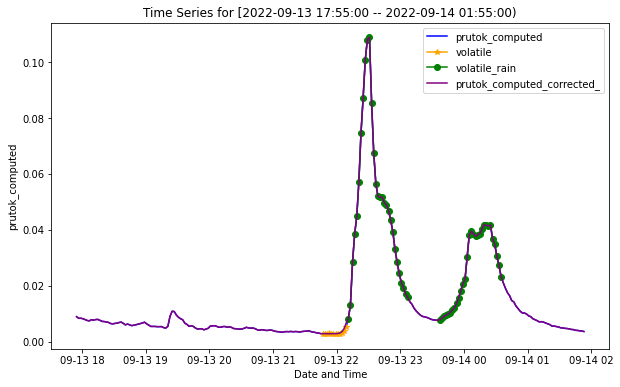

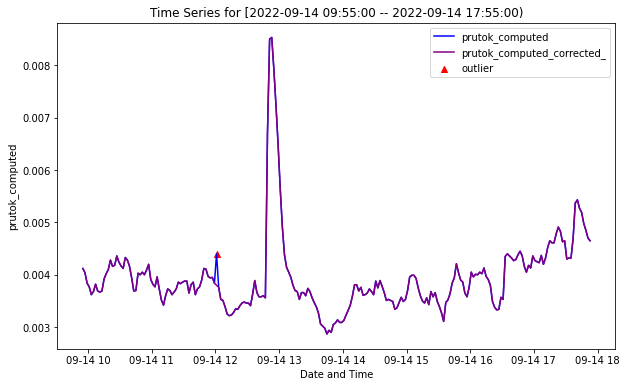

In [218]:
rr.plot_categories(period=8, corrections=rr.main_var+"_corrected_")

add summaries method to DataExplorer

In [22]:
explorer.TS_objects

{'MP1': <DHI_functions.TS_Class at 0x2062e03a710>,
 'MP2': <DHI_functions.TS_Class at 0x2062a4c29d0>,
 'MP3': <DHI_functions.TS_Class at 0x2062de37c50>,
 'MP4': <DHI_functions.TS_Class at 0x20630379a50>,
 'MP5': <DHI_functions.TS_Class at 0x2062e03a590>,
 'MP6': <DHI_functions.TS_Class at 0x2062e03aad0>,
 'MP7': <DHI_functions.TS_Class at 0x2062dfb9810>,
 'first': <DHI_functions.TS_Class at 0x2062d342c50>,
 '_joined': <DHI_functions.TS_Class at 0x206303c24d0>}

In [25]:
ts.name

'MP7'

In [212]:
for ts in explorer.TS_objects.values():
    print(ts.name)
    ts.data = correct_data(ts.data, ts.main_var)

MP1
MP2
MP3
MP4
MP5
MP6
MP7
first
_joined


KeyError: 'prutok_computed_OK'

In [123]:
dd = correct_data(ts_data.data, "prutok_computed")

In [130]:
dd.columns

Index(['date', ' Hl-Vega-OK', 'Hl-US-Odlehc', 'Hladina KDO', 'Teplota KDO',
       'Rychlost KDO', 'Prietok_l', 'Napatie_AKU2', 'Napatie_AKU',
       'prutok_computed', 'rain', 'rain_2m', 'prutok_computed_diff_1_',
       'prutok_computed_diff_2_', 'site', 'prutok_computed_category',
       'prutok_computed_OK', 'prutok_computed_const_value',
       'prutok_computed_outlier', 'prutok_computed_volatile',
       'prutok_computed_volatile_rain', 'prutok_computed_zero_value',
       'prutok_computed_corrected_', '_MA_5', '_MA_15', '_MA_30',
       'prutok_computed_corrected__category', 'prutok_computed_corrected__OK',
       'prutok_computed_corrected__const_value',
       'prutok_computed_corrected__outlier',
       'prutok_computed_corrected__volatile',
       'prutok_computed_corrected__volatile_rain',
       'prutok_computed_corrected__zero_value'],
      dtype='object')

In [126]:
ts_data.data = dd

In [128]:
ts_data.classify(classif_var="prutok_computed_corrected_")

In [36]:
TS_Class.DEFAULT_CLASSIF_PARAMS

{'data': 8,
 'classif_var': None,
 'W_0': 3,
 'c_1': 2.5,
 'W_1': 30,
 'c_2': 1,
 'W_2': 30,
 'p_1': 0.7,
 'W_3': 5,
 'p_2': 0.9,
 'tol_vol_1': 5,
 'tol_vol_2': 5,
 'tol_rain_1': 5,
 'tol_rain_2': 10,
 'volatile_diffs': True}

In [ ]:
ts_data.plot_categories(classif_var="prutok_computed_corrected_",period=8,only_events=True,categories=["outlier","const_value"])

In [ ]:
ts_data.plot(include=["prutok_computed_corrected_"],period=12)

In [54]:
outlier_indic = dd["prutok_computed_category"] == "outlier"

In [2]:
path = ".\dhi_data2"

In [3]:
path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\dhi_data2"   ## Alex's path

In [4]:
files = os.listdir(path)

In [5]:
files

['MP1_hladina_result.csv',
 'MP1_hladina_TL_zdroj.csv',
 'MP1_hladina_UZ_zdroj.csv',
 'MP1_prutok_computed.csv',
 'MP1_rychlost_result.csv',
 'MP1_rychlost_zdroj.csv',
 'MP2_hladina_result.csv',
 'MP2_hladina_TL_zdroj.csv',
 'MP2_hladina_UZ_zdroj.csv',
 'MP2_prutok_computed.csv',
 'MP2_rychlost_result.csv',
 'MP2_rychlost_zdroj.csv',
 'MP3_hladina TL_zdroj.csv',
 'MP3_hladina UZ_zdroj.csv',
 'MP3_hladina_result.csv',
 'MP3_prutok_computed.csv',
 'MP3_rychlost_result.csv',
 'MP3_rychlost_zdroj.csv',
 'MP4_hladina TL_zdroj.csv',
 'MP4_hladina UZ_zdroj.csv',
 'MP4_hladina_result.csv',
 'MP4_prutok_computed.csv',
 'MP4_rychlost_result.csv',
 'MP4_rychlost_zdroj.csv',
 'MP5_hladina_result.csv',
 'MP5_hladina_UZ_zdroj.csv',
 'MP5_prutok_computed.csv',
 'MP5_rychlost_result.csv',
 'MP5_rychlost_zdroj.csv',
 'MP6_hladina TL_zdroj.csv',
 'MP6_hladina UZ_zdroj.csv',
 'MP6_hladina_result.csv',
 'MP6_prutok_computed.csv',
 'MP6_rychlost_result.csv',
 'MP6_rychlost_zdroj.csv',
 'MP7_hladina TL_zdro

In [6]:
dataframes_dict = load_series(path)

In [7]:
site_dataframes = merge_site_data(dataframes_dict)
site_dataframes = clean_data(site_dataframes)

In [8]:
first_path = ".\Q01_HL_23.csv"
rain_path = ".\SR02_H2_27374.csv"

first_path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\Q01_HL_23.csv"   ## Alex's path
rain_path = "d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\SR02_H2_27374.csv"    ## Alex's path

In [9]:
first_data = pd.read_csv(first_path, skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "prutok_computed"],
                  sep = ";", decimal=',')

rain = pd.read_csv(rain_path, skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

first_data["date"] = pd.to_datetime(first_data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

rain["date"] = rain.index
rain.index = range(rain.shape[0])
first_data = first_data.merge(rain, on='date', how='left')

In [10]:
site_dataframes["first"] = first_data

In [11]:
main_vars = []

### explorer

In [12]:
explorer = DataExplorer(site_dataframes)

In [13]:
sites = explorer.sites

In [14]:
sites

['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'MP7', 'first', '_joined']

In [ ]:
explorer.TS_objects['MP1'].plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"])

In [ ]:
explorer.TS_objects['MP5'].plot(include=["CMA_rob_bounds","CMA_bounds_2sd"], period=12, start_time="0:00:00", 
             start_time_2="6:00:00", include_2 = ["CMA_rob_bounds", "CMA_bounds_2sd"])

In [17]:
import mikeio

In [113]:
dfs_path = "d:\moje_dokumenty\Desktop\DHI\dfs_files"
for site in explorer.main_sites:
    print(site)
    outputFileName = dfs_path + "\\"+site + ".dfs0"
    ts = explorer.TS_objects[site]
    outputDataframe = ts.data[[ts.main_var, "date"]]
    outputDataframe.set_index('date', inplace=True)
    outputDataframe.to_dfs0(outputFileName, items=[mikeio.ItemInfo(ts.main_var)])

MP1
MP2
MP3
MP4
MP5
MP6
MP7
first


In [117]:
dfs_from_dfs0 = []
dfs_path = "d:\moje_dokumenty\Desktop\DHI\dfs_files"
for site in explorer.main_sites:
    outputFileName = dfs_path + "\\"+site + ".dfs0"
    print(outputFileName)
    inputDfs = mikeio.Dfs0(outputFileName)
    inputDataframe = inputDfs.to_dataframe()
    dfs_from_dfs0.append(inputDataframe)

d:\moje_dokumenty\Desktop\DHI\dfs_files\MP1.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\MP2.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\MP3.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\MP4.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\MP5.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\MP6.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\MP7.dfs0
d:\moje_dokumenty\Desktop\DHI\dfs_files\first.dfs0


In [15]:
ts_data = explorer.TS_objects['first'].copy() 

In [16]:
ts_data.classify()

In [17]:
vars_of_interest = {}

for key in site_dataframes:
    df = site_dataframes[key]
    nas = df.isna().sum()
    goods = list(nas[nas==0].index)
    goods.remove("date")
    goods.remove("prutok_computed")
    #goods.remove("site")
    vars_of_interest[key] = goods
    #print(key)
    #print(df.isna().sum())
    
print(vars_of_interest)
del vars_of_interest["first"] 

{'MP1': ['hladina_result', 'rychlost_result'], 'MP6': ['hladina_result', 'rychlost_result'], 'MP3': ['hladina_result', 'rychlost_result'], 'MP5': ['hladina_result', 'rychlost_result'], 'MP4': ['hladina_result', 'rychlost_result'], 'MP7': ['hladina_TL_zdroj', 'rychlost_zdroj'], 'MP2': ['hladina_result', 'rychlost_result'], 'first': [' Hl-Vega-OK', 'Hl-US-Odlehc', 'Hladina KDO', 'Teplota KDO', 'Rychlost KDO', 'Prietok_l', 'Napatie_AKU2', 'Napatie_AKU']}


In [18]:
vars_of_interest = {k:v for k,v in sorted(vars_of_interest.items())}
vars_of_interest

{'MP1': ['hladina_result', 'rychlost_result'],
 'MP2': ['hladina_result', 'rychlost_result'],
 'MP3': ['hladina_result', 'rychlost_result'],
 'MP4': ['hladina_result', 'rychlost_result'],
 'MP5': ['hladina_result', 'rychlost_result'],
 'MP6': ['hladina_result', 'rychlost_result'],
 'MP7': ['hladina_TL_zdroj', 'rychlost_zdroj']}

In [19]:
explorer.main_sites

['MP1', 'MP2', 'MP3', 'MP4', 'MP5', 'MP6', 'MP7', 'first']

In [19]:
explorer.classify()
print("da")
outs = explorer.classify(classif_vars_dict = vars_of_interest)

da


In [21]:
# same as above
for site in explorer.main_sites:
    if site == "first":
        continue
    ts = explorer.TS_objects[site] 
    classif_var = vars_of_interest[site][0]  #hladina
    ts.classify()
    ts.classify(classif_var=classif_var)
    classif_var = vars_of_interest[site][1]  #rychlost
    ts.classify(classif_var=classif_var)

In [22]:
i=-1

MP1


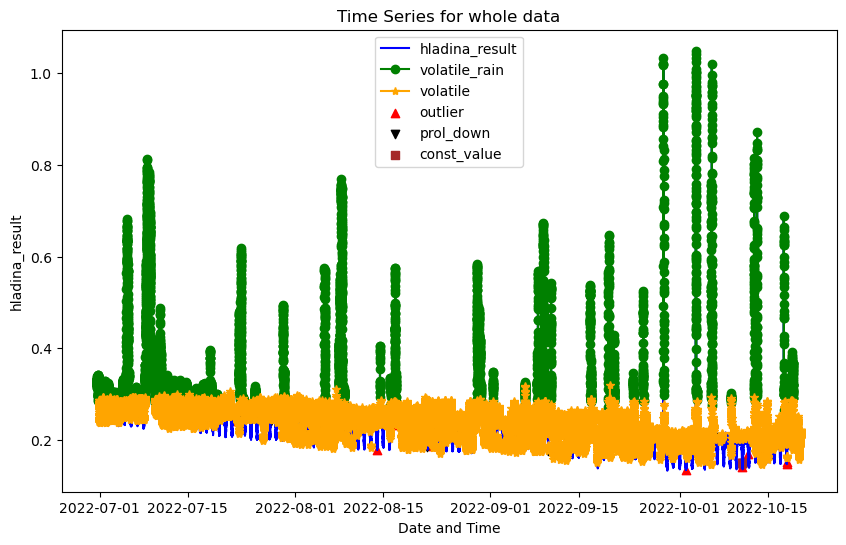

In [23]:
i+=1
print(sites[i])
classif_var = vars_of_interest[sites[i]][0]  #hladina
explorer.TS_objects[sites[i]].plot_categories(classif_var=classif_var)

MP1


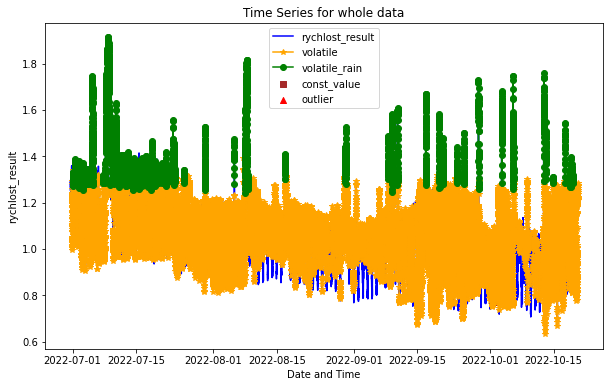

In [29]:
#i+=1
print(sites[i])
classif_var = vars_of_interest[sites[i]][1]  #rychlost
explorer.TS_objects[sites[i]].plot_categories(classif_var=classif_var)

MP1


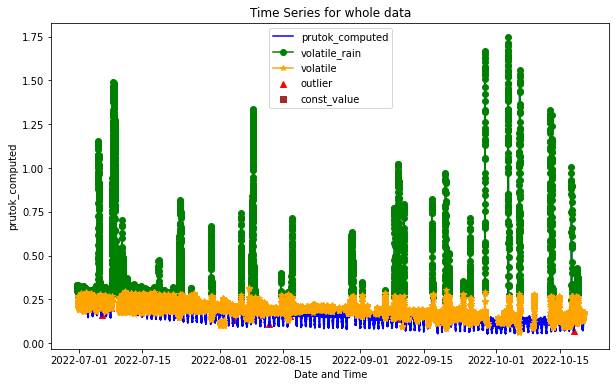

In [30]:
print(sites[i])
explorer.TS_objects[sites[i]].plot_categories()

# xx

In [20]:
summaries = []
for site in explorer.main_sites:
    summary = summarize_event_groups(explorer.TS_objects[site].data, classif_var="prutok_computed")
    cols = list(summary.columns)
    summary["site"] = site
    summary["var"] = "prutok_computed"
    cols = ["site", "var"] + cols
    summaries.append(summary[cols])
    if site=="first":
        continue
    varies = vars_of_interest[site]
    for var in varies:
        summary = summarize_event_groups(explorer.TS_objects[site].data, classif_var=var)
        cols = list(summary.columns)
        summary["site"] = site
        summary["var"] = var
        cols = ["site", "var"] + cols
        summaries.append(summary[cols])

TypeError: cannot concatenate object of type '<class 'dict'>'; only Series and DataFrame objs are valid

In [159]:
summies_df = pd.concat(summaries)
i=-1

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [ ]:
i+=1
summies_df[summies_df["site"]==explorer.main_sites[i]].sort_values("category")

In [37]:
indic = ts_data.data["prutok_computed"].rolling(10, center=True).apply(loc_extr)

In [549]:
ts_data.data["loc_peaks_10"] = np.where(indic, ts_data.data["prutok_computed"], np.nan)

In [ ]:
ts_data.plot(include=["loc_peaks_10"],marker="*",period=8)

In [564]:
ts_data_2 = TS_Class(ts_data.data,main_var="prutok_computed")

In [565]:
ts_data_2.classify(volatile_diffs=True)

In [569]:
ts_data.data["prutok_computed_volatile_rain_2"] = ts_data_2.data["prutok_computed_volatile_rain"]
ts_data.data["prutok_computed_volatile_2"] = ts_data_2.data["prutok_computed_volatile"]

In [ ]:
ts_data.plot(include=["prutok_computed_volatile_rain", "prutok_computed_volatile"], start_time_2 = "start",
            include_2 = ["prutok_computed_volatile_rain_2", "prutok_computed_volatile_2"], period=8)

In [507]:
trend = TS_Class.time_trend

In [509]:
ts_data.data["deriv2"] = ts_data.data["prutok_computed"].rolling(30, center=True).apply(lambda x: trend(x, degree=2))
ts_data.data["deriv3"] = ts_data.data["prutok_computed"].rolling(30, center=True).apply(lambda x: trend(x, degree=3))

In [534]:
ts_data.data["deriv4"] = ts_data.data["prutok_computed"].rolling(30, center=True).apply(lambda x: trend(x, degree=4))
ts_data.data["zero"] = 0

In [2]:
ts_data.data["prutok_computed_div10"] = ts_data.data["prutok_computed"]/10

NameError: name 'ts_data' is not defined

In [ ]:
ts_data.plot(variable="deriv", include=["deriv2","deriv3","deriv4","zero","prutok_computed_div10"], period = 8, 
             start_time_2 = "start", variable_2="prutok_computed")

In [28]:
i=-1

In [36]:
i+=1
site_dataframes[sorted(site_dataframes.keys())[i]]

date  hladina_TL_zdroj  hladina_UZ_zdroj  hladina_result  \
0     2019-07-25 15:03:00             0.006               NaN             NaN   
1     2019-07-25 15:05:00             0.006               NaN             NaN   
2     2019-07-25 15:07:00             0.006               NaN             NaN   
3     2019-07-25 15:11:00             0.006               NaN             NaN   
4     2019-07-25 15:13:00             0.065             0.785             NaN   
...                   ...               ...               ...             ...   
66322 2019-10-25 23:51:00             0.253             0.246         0.25297   
66323 2019-10-25 23:53:00             0.251             0.240         0.25097   
66324 2019-10-25 23:55:00             0.251             0.243         0.25097   
66325 2019-10-25 23:57:00             0.251             0.244         0.25097   
66326 2019-10-25 23:59:00             0.251             0.244         0.25097   

       prutok_computed  rychlost_result  rychlost_zdroj  
0               0.0000              NaN            0.00  
1               0.0000              NaN            0.00  
2               0.0000              NaN            0.00  
3               0.0000              NaN            0.00  
4               0.0294              NaN            0.14  
...                ...              ...             ...  
66322           0.0000          0.52037            0.00  
66323           0.0000          0.52037            0.00  
66324           0.0000          0.52037            0.00  
66325           0.0000          0.52037            0.00  
66326           0.0000          0.52037            0.00  

[66327 rows x 7 columns]

In [31]:
for site in sorted(site_dataframes.keys()):
    print(site)
    df = site_dataframes[site]
    print(df.shape)
    print(site + " NAs:")
    print(df.isna().sum())
    print(f"{site} from {df['date'].min()} to {df['date'].max()}")
    print(site + " observation intervals:")
    print(df['date'].diff().dropna().value_counts())
    print(df["prutok_computed"].describe())

MP1
(80472, 7)
MP1 NAs:
date                  0
hladina_result        0
hladina_TL_zdroj    365
hladina_UZ_zdroj    364
prutok_computed       0
rychlost_result       0
rychlost_zdroj      365
dtype: int64
MP1 from 2022-06-30 13:12:00 to 2022-10-20 07:34:00
MP1 observation intervals:
0 days 00:02:00    80471
Name: date, dtype: int64
count    80472.000000
mean         0.184037
std          0.127910
min          0.052010
25%          0.125930
50%          0.163455
75%          0.196762
max          1.745810
Name: prutok_computed, dtype: float64
MP2
(66254, 7)
MP2 NAs:
date                   0
hladina_result         0
hladina_TL_zdroj    2092
hladina_UZ_zdroj    2092
prutok_computed        0
rychlost_result        0
rychlost_zdroj      2092
dtype: int64
MP2 from 2022-06-15 09:55:00 to 2022-09-15 10:21:00
MP2 observation intervals:
0 days 00:02:00    66253
Name: date, dtype: int64
count    66254.000000
mean         0.005588
std          0.010546
min          0.001350
25%          0.003350
5

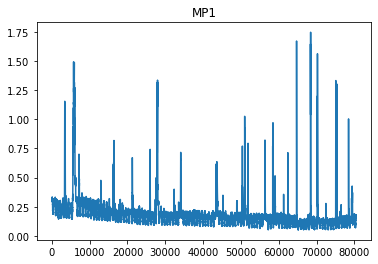

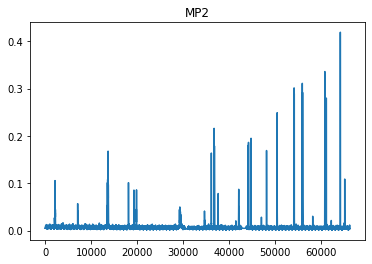

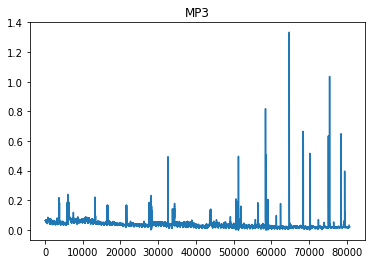

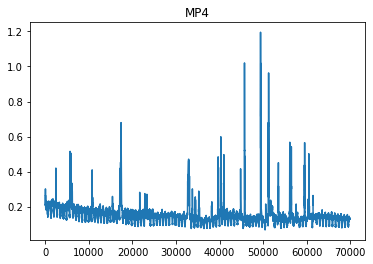

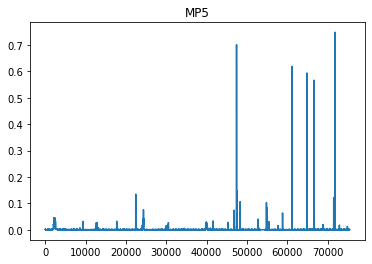

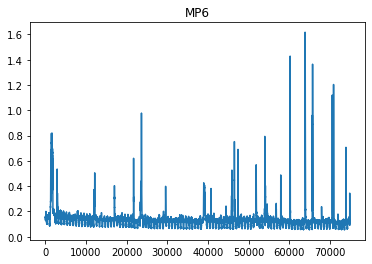

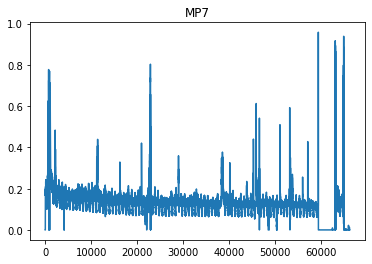

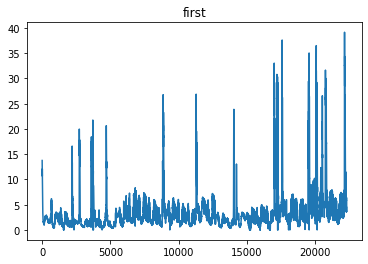

In [35]:
for site in sorted(site_dataframes.keys()):
    df = site_dataframes[site]
    df["prutok_computed"].plot(title = site)
    plt.show()
    plt.close()

## example of saving figures and plotting them again after some adjustments

In [ ]:
figs = ee.plot("prutok_computed_diff_1_",period=48, start_time_2 = "2:00:00", rain_var="rain_2m", window_2 = 80,
              ret_plots = True, include_2 = ["prutok_computed"])

In [ ]:
show_again = Plotter.show_again

for i, f in enumerate(figs):
    ax = f[1]
    ax[0].set_title(f"New Title Left {i+1}")
    ax[1].set_title(f"New Title Right {i+1}")

figures = [f[0] for f in figs]

show_again(figures)